In [1]:
from past.builtins import basestring
from builtins import zip
from builtins import map
from builtins import str
from builtins import range
from past.utils import old_div
import collections
import cv2
import gc
import h5py
import itertools
import logging
import numpy as np
from numpy.fft import ifftshift
import os
import pylab as pl
import tifffile
from typing import List, Optional, Tuple
from skimage.transform import resize as resize_sk
from skimage.transform import warp as warp_sk

from builtins import str
from builtins import range
from past.utils import old_div

import cv2
from functools import partial
import h5py
import logging
from matplotlib import animation
import numpy as np
import os
from PIL import Image  # $ pip install pillow
import pylab as pl
import scipy.ndimage
import scipy
from scipy.io import loadmat
from skimage.transform import warp, AffineTransform
from skimage.feature import match_template
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, IncrementalPCA, FastICA
from sklearn.metrics.pairwise import euclidean_distances
import sys
import tifffile
from tqdm import tqdm
from typing import Any, Dict, List, Tuple, Union
import warnings
from zipfile import ZipFile

try:
    cv2.setNumThreads(0)
except:
    pass

from cv2 import dft as fftn
from cv2 import idft as ifftn
opencv = True

try:
    import pycuda.gpuarray as gpuarray
    import pycuda.driver as cudadrv
    import atexit
    HAS_CUDA = True
except ImportError:
    HAS_CUDA = False

try:
    profile
except:
    def profile(a): return a

    from builtins import str
from builtins import range
from past.utils import old_div

import cv2
import h5py
import logging
import numpy as np
import os
import pathlib
import pylab as pl
import scipy
from scipy.sparse import spdiags, issparse, csc_matrix, csr_matrix
import scipy.ndimage.morphology as morph
from skimage.feature.peak import _get_high_intensity_peaks
import tifffile
from typing import List

from builtins import str
from builtins import range
from past.utils import old_div

import cv2
import h5py
import logging
import numpy as np
import os
import pathlib
import pylab as pl
import scipy
from scipy.sparse import spdiags, issparse, csc_matrix, csr_matrix
import scipy.ndimage.morphology as morph
from skimage.feature.peak import _get_high_intensity_peaks
import tifffile
from typing import List


In [2]:
def get_file_size(file_name, var_name_hdf5='mov'):
    """ Computes the dimensions of a file or a list of files without loading
    it/them in memory. An exception is thrown if the files have FOVs with
    different sizes
        Args:
            file_name: str/filePath or various list types
                locations of file(s)
            var_name_hdf5: 'str'
                if loading from hdf5 name of the dataset to load
        Returns:
            dims: list
                dimensions of FOV
            T: list
                number of timesteps in each file
    """
    if isinstance(file_name, pathlib.Path):
        # We want to support these as input, but str has a broader set of operations that we'd like to use, so let's just convert.
	# (specifically, filePath types don't support subscripting)
        file_name = str(file_name)
    if isinstance(file_name, str):
        if os.path.exists(file_name):
            _, extension = os.path.splitext(file_name)[:2]
            extension = extension.lower()
            if extension == '.mat':
                byte_stream, file_opened = scipy.io.matlab.mio._open_file(file_name, appendmat=False)
                mjv, mnv = scipy.io.matlab.mio.get_matfile_version(byte_stream)
                if mjv == 2:
                    extension = '.h5'
            if extension in ['.tif', '.tiff', '.btf']:
                tffl = tifffile.TiffFile(file_name)
                siz = tffl.series[0].shape
                T, dims = siz[0], siz[1:]
            elif extension in ('.avi', '.mkv'):
                cap = cv2.VideoCapture(file_name)
                dims = [0, 0]
                try:
                    T = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                    dims[1] = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                    dims[0] = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                except():
                    print('Roll back to opencv 2')
                    T = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
                    dims[1] = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_WIDTH))
                    dims[0] = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_HEIGHT))
            elif extension == '.mmap':
                filename = os.path.split(file_name)[-1]
                Yr, dims, T = load_memmap(os.path.join(
                        os.path.split(file_name)[0], filename))
            elif extension in ('.h5', '.hdf5', '.nwb'):
                with h5py.File(file_name, "r") as f:
                    kk = list(f.keys())
                    if len(kk) == 1:
                        siz = f[kk[0]].shape
                    elif var_name_hdf5 in f:
                        if extension == '.nwb':
                            siz = f[var_name_hdf5]['data'].shape
                        else:
                            siz = f[var_name_hdf5].shape
                    elif var_name_hdf5 in f['acquisition']:
                        siz = f['acquisition'][var_name_hdf5]['data'].shape
                    else:
                        logging.error('The file does not contain a variable' +
                                      'named {0}'.format(var_name_hdf5))
                        raise Exception('Variable not found. Use one of the above')
                T, dims = siz[0], siz[1:]
            elif extension in ('.sbx'):
                from ...base.movies import loadmat_sbx
                info = loadmat_sbx(file_name[:-4]+ '.mat')['info']
                dims = tuple((info['sz']).astype(int))
                # Defining number of channels/size factor
                if info['channels'] == 1:
                    info['nChan'] = 2
                    factor = 1
                elif info['channels'] == 2:
                    info['nChan'] = 1
                    factor = 2
                elif info['channels'] == 3:
                    info['nChan'] = 1
                    factor = 2
            
                # Determine number of frames in whole file
                T = int(os.path.getsize(
                    file_name[:-4] + '.sbx') / info['recordsPerBuffer'] / info['sz'][1] * factor / 4 - 1)
                
            else:
                raise Exception('Unknown file type')
            dims = tuple(dims)
        else:
            raise Exception('File not found!')
    elif isinstance(file_name, tuple):
        from ...base.movies import load
        dims = load(file_name[0], var_name_hdf5=var_name_hdf5).shape
        T = len(file_name)

    elif isinstance(file_name, list):
        if len(file_name) == 1:
            dims, T = get_file_size(file_name[0], var_name_hdf5=var_name_hdf5)
        else:
            dims, T = zip(*[get_file_size(fn, var_name_hdf5=var_name_hdf5)
                for fn in file_name])
    else:
        raise Exception('Unknown input type')
    return dims, T

#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""

The functions apply_shifts_dft, register_translation, _compute_error, _compute_phasediff, and _upsampled_dft are from
SIMA (https://github.com/losonczylab/sima), licensed under the  GNU GENERAL PUBLIC LICENSE, Version 2, 1991.
These same functions were adapted from sckikit-image, licensed as follows:

Copyright (C) 2011, the scikit-image team
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are
 met:

  1. Redistributions of source code must retain the above copyright
     notice, this list of conditions and the following disclaimer.
  2. Redistributions in binary form must reproduce the above copyright
     notice, this list of conditions and the following disclaimer in
     the documentation and/or other materials provided with the
     distribution.
  3. Neither the name of skimage nor the names of its contributors may be
     used to endorse or promote products derived from this software without
     specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE AUTHOR ``AS IS'' AND ANY EXPRESS OR
 IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
 WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
 DISCLAIMED. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR ANY DIRECT,
 INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
 (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
 SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION)
 HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT,
 STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING
 IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
 POSSIBILITY OF SUCH DAMAGE.

"""

from past.builtins import basestring
from builtins import zip
from builtins import map
from builtins import str
from builtins import range
from past.utils import old_div
import collections
import cv2
import gc
import h5py
import itertools
import logging
import numpy as np
from numpy.fft import ifftshift
import os
import pylab as pl
import tifffile
from typing import List, Optional, Tuple
from skimage.transform import resize as resize_sk
from skimage.transform import warp as warp_sk



class MotionCorrect(object):
    """
        class implementing motion correction operations
       """

    def __init__(self, fname, min_mov=None, dview=None, max_shifts=(6, 6), niter_rig=1, splits_rig=14, num_splits_to_process_rig=None,
                 strides=(96, 96), overlaps=(32, 32), splits_els=14, num_splits_to_process_els=None,
                 upsample_factor_grid=4, max_deviation_rigid=3, shifts_opencv=True, nonneg_movie=True, gSig_filt=None,
                 use_cuda=False, border_nan=True, pw_rigid=False, num_frames_split=80, var_name_hdf5='mov',is3D=False,
                 indices=(slice(None), slice(None))):
        """
        Constructor class for motion correction operations

        Args:
           fname: str
               path to file to motion correct

           min_mov: int16 or float32
               estimated minimum value of the movie to produce an output that is positive

           dview: ipyparallel view object list
               to perform parallel computing, if NOne will operate in single thread

           max_shifts: tuple
               maximum allow rigid shift

           niter_rig':int
               maximum number of iterations rigid motion correction, in general is 1. 0
               will quickly initialize a template with the first frames

           splits_rig': int
            for parallelization split the movies in  num_splits chuncks across time

           num_splits_to_process_rig: list,
               if none all the splits are processed and the movie is saved, otherwise at each iteration
               num_splits_to_process_rig are considered

           strides: tuple
               intervals at which patches are laid out for motion correction

           overlaps: tuple
               overlap between pathes (size of patch strides+overlaps)

           pw_rigig: bool, default: False
               flag for performing motion correction when calling motion_correct

           splits_els':list
               for parallelization split the movies in  num_splits chuncks across time

           num_splits_to_process_els: list,
               if none all the splits are processed and the movie is saved  otherwise at each iteration
                num_splits_to_process_els are considered

           upsample_factor_grid:int,
               upsample factor of shifts per patches to avoid smearing when merging patches

           max_deviation_rigid:int
               maximum deviation allowed for patch with respect to rigid shift

           shifts_opencv: Bool
               apply shifts fast way (but smoothing results)

           nonneg_movie: boolean
               make the SAVED movie and template mostly nonnegative by removing min_mov from movie

           use_cuda : bool, optional
               Use skcuda.fft (if available). Default: False

           border_nan : bool or string, optional
               Specifies how to deal with borders. (True, False, 'copy', 'min')

           num_frames_split: int, default: 80
               Number of frames in each batch. Used when cosntructing the options
               through the params object

           var_name_hdf5: str, default: 'mov'
               If loading from hdf5, name of the variable to load

            is3D: bool, default: False
               Flag for 3D motion correction

            indices: tuple(slice), default: (slice(None), slice(None))
               Use that to apply motion correction only on a part of the FOV

       Returns:
           self

        """
        if 'ndarray' in str(type(fname)):
            logging.info('Creating file for motion correction "tmp_mov_mot_corr.hdf5"')
            cm.movie(fname).save('./tmp_mov_mot_corr.hdf5')
            fname = ['./tmp_mov_mot_corr.hdf5']

        if type(fname) is not list:
            fname = [fname]

        self.fname = fname
        self.dview = dview
        self.max_shifts = max_shifts
        self.niter_rig = niter_rig
        self.splits_rig = splits_rig
        self.num_splits_to_process_rig = num_splits_to_process_rig
        self.strides = strides
        self.overlaps = overlaps
        self.splits_els = splits_els
        self.num_splits_to_process_els = num_splits_to_process_els
        self.upsample_factor_grid = upsample_factor_grid
        self.max_deviation_rigid = max_deviation_rigid
        self.shifts_opencv = bool(shifts_opencv)
        self.min_mov = min_mov
        self.nonneg_movie = nonneg_movie
        self.gSig_filt = gSig_filt
        self.use_cuda = bool(use_cuda)
        self.border_nan = border_nan
        self.pw_rigid = bool(pw_rigid)
        self.var_name_hdf5 = var_name_hdf5
        self.is3D = bool(is3D)
        self.indices = indices
        if self.use_cuda and not HAS_CUDA:
            logging.debug("pycuda is unavailable. Falling back to default FFT.")

    def motion_correct(self, template=None, save_movie=False):
        """general function for performing all types of motion correction. The
        function will perform either rigid or piecewise rigid motion correction
        depending on the attribute self.pw_rigid and will perform high pass
        spatial filtering for determining the motion (used in 1p data) if the
        attribute self.gSig_filt is not None. A template can be passed, and the
        output can be saved as a memory mapped file.

        Args:
            template: ndarray, default: None
                template provided by user for motion correction

            save_movie: bool, default: False
                flag for saving motion corrected file(s) as memory mapped file(s)

        Returns:
            self
        """
        # TODO: Review the docs here, and also why we would ever return self
        #       from a method that is not a constructor
        if self.min_mov is None:
            if self.gSig_filt is None:
                # self.min_mov = np.array([load(self.fname[0],
                #                                  var_name_hdf5=self.var_name_hdf5,
                #                                  subindices=slice(400))]).min()
                iterator = load_iter(self.fname[0],
                                                    var_name_hdf5=self.var_name_hdf5)
                mi = np.inf
                for _ in range(400):
                    try:
                        mi = min(mi, next(iterator).min()[()])
                    except StopIteration:
                        break
                self.min_mov = mi
            else:
                self.min_mov = np.array([high_pass_filter_space(m_, self.gSig_filt)
                    for m_ in load(self.fname[0], var_name_hdf5=self.var_name_hdf5,
                                      subindices=slice(400))]).min()

        if self.pw_rigid:
            self.motion_correct_pwrigid(template=template, save_movie=save_movie)
            if self.is3D:
                # TODO - error at this point after saving
                b0 = np.ceil(np.max([np.max(np.abs(self.x_shifts_els)),
                                     np.max(np.abs(self.y_shifts_els)),
                                     np.max(np.abs(self.z_shifts_els))]))
            else:
                b0 = np.ceil(np.maximum(np.max(np.abs(self.x_shifts_els)),
                                    np.max(np.abs(self.y_shifts_els))))
        else:
            self.motion_correct_rigid(template=template, save_movie=save_movie)
            b0 = np.ceil(np.max(np.abs(self.shifts_rig)))
        self.border_to_0 = b0.astype(np.int)
        self.mmap_file = self.fname_tot_els if self.pw_rigid else self.fname_tot_rig
        return self

    def motion_correct_rigid(self, template=None, save_movie=False) -> None:
        """
        Perform rigid motion correction

        Args:
            template: ndarray 2D (or 3D)
                if known, one can pass a template to register the frames to

            save_movie_rigid:Bool
                save the movies vs just get the template

        Important Fields:
            self.fname_tot_rig: name of the mmap file saved

            self.total_template_rig: template updated by iterating  over the chunks

            self.templates_rig: list of templates. one for each chunk

            self.shifts_rig: shifts in x and y (and z if 3D) per frame
        """
        logging.debug('Entering Rigid Motion Correction')
        logging.debug(-self.min_mov)  # XXX why the minus?
        self.total_template_rig = template
        self.templates_rig:List = []
        self.fname_tot_rig:List = []
        self.shifts_rig:List = []

        for fname_cur in self.fname:
            _fname_tot_rig, _total_template_rig, _templates_rig, _shifts_rig = motion_correct_batch_rigid(
                fname_cur,
                self.max_shifts,
                dview=self.dview,
                splits=self.splits_rig,
                num_splits_to_process=self.num_splits_to_process_rig,
                num_iter=self.niter_rig,
                template=self.total_template_rig,
                shifts_opencv=self.shifts_opencv,
                save_movie_rigid=save_movie,
                add_to_movie=-self.min_mov,
                nonneg_movie=self.nonneg_movie,
                gSig_filt=self.gSig_filt,
                use_cuda=self.use_cuda,
                border_nan=self.border_nan,
                var_name_hdf5=self.var_name_hdf5,
                is3D=self.is3D,
                indices=self.indices)
            if template is None:
                self.total_template_rig = _total_template_rig

            self.templates_rig += _templates_rig
            self.fname_tot_rig += [_fname_tot_rig]
            self.shifts_rig += _shifts_rig

    def motion_correct_pwrigid(self, save_movie:bool=True, template:np.ndarray=None, show_template:bool=False) -> None:
        """Perform pw-rigid motion correction

        Args:
            save_movie:Bool
                save the movies vs just get the template

            template: ndarray 2D (or 3D)
                if known, one can pass a template to register the frames to

            show_template: boolean
                whether to show the updated template at each iteration

        Important Fields:
            self.fname_tot_els: name of the mmap file saved
            self.templates_els: template updated by iterating  over the chunks
            self.x_shifts_els: shifts in x per frame per patch
            self.y_shifts_els: shifts in y per frame per patch
            self.z_shifts_els: shifts in z per frame per patch (if 3D)
            self.coord_shifts_els: coordinates associated to the patch for
            values in x_shifts_els and y_shifts_els (and z_shifts_els if 3D)
            self.total_template_els: list of templates. one for each chunk

        Raises:
            Exception: 'Error: Template contains NaNs, Please review the parameters'
        """

        num_iter = 1
        if template is None:
            logging.info('Generating template by rigid motion correction')
            self.motion_correct_rigid()
            self.total_template_els = self.total_template_rig.copy()
        else:
            self.total_template_els = template

        self.fname_tot_els:List = []
        self.templates_els:List = []
        self.x_shifts_els:List = []
        self.y_shifts_els:List = []
        if self.is3D:
            self.z_shifts_els:List = []

        self.coord_shifts_els:List = []
        for name_cur in self.fname:
            _fname_tot_els, new_template_els, _templates_els,\
                _x_shifts_els, _y_shifts_els, _z_shifts_els, _coord_shifts_els = motion_correct_batch_pwrigid(
                    name_cur, self.max_shifts, self.strides, self.overlaps, -self.min_mov,
                    dview=self.dview, upsample_factor_grid=self.upsample_factor_grid,
                    max_deviation_rigid=self.max_deviation_rigid, splits=self.splits_els,
                    num_splits_to_process=None, num_iter=num_iter, template=self.total_template_els,
                    shifts_opencv=self.shifts_opencv, save_movie=save_movie, nonneg_movie=self.nonneg_movie, gSig_filt=self.gSig_filt,
                    use_cuda=self.use_cuda, border_nan=self.border_nan, var_name_hdf5=self.var_name_hdf5, is3D=self.is3D,
                    indices=self.indices)
            if not self.is3D:
                if show_template:
                    pl.imshow(new_template_els)
                    pl.pause(.5)
            if np.isnan(np.sum(new_template_els)):
                raise Exception(
                    'Template contains NaNs, something went wrong. Reconsider the parameters')

            if template is None:
                self.total_template_els = new_template_els

            self.fname_tot_els += [_fname_tot_els]
            self.templates_els += _templates_els
            self.x_shifts_els += _x_shifts_els
            self.y_shifts_els += _y_shifts_els
            if self.is3D:
                self.z_shifts_els += _z_shifts_els
            self.coord_shifts_els += _coord_shifts_els

    def apply_shifts_movie(self, fname, rigid_shifts:bool=None, save_memmap:bool=False,
                           save_base_name:str='MC', order:str='F', remove_min:bool=True):
        """
        Applies shifts found by registering one file to a different file. Useful
        for cases when shifts computed from a structural channel are applied to a
        functional channel. Currently only application of shifts through openCV is
        supported. Returns either cm.movie or the path to a memory mapped file.

        Args:
            fname: str of List[str]
                name(s) of the movie to motion correct. It should not contain
                nans. All the loadable formats from CaImAn are acceptable

            rigid_shifts: bool (True)
                apply rigid or pw-rigid shifts (must exist in the mc object)
                deprectated (read directly from mc.pw_rigid)

            save_memmap: bool (False)
                flag for saving the resulting file in memory mapped form

            save_base_name: str ['MC']
                base name for memory mapped file name

            order: 'F' or 'C' ['F']
                order of resulting memory mapped file

            remove_min: bool (True)
                If minimum value is negative, subtract it from the data

        Returns:
            m_reg: caiman movie object
                caiman movie object with applied shifts (not memory mapped)
        """

        Y = load(fname).astype(np.float32)
        if remove_min: 
            ymin = Y.min()
            if ymin < 0:
                Y -= Y.min()

        if rigid_shifts is not None:
            logging.warning('The rigid_shifts flag is deprecated and it is ' +
                            'being ignored. The value is read directly from' +
                            ' mc.pw_rigid and is current set to the opposite' +
                            ' of {}'.format(self.pw_rigid))            
        
        if self.pw_rigid is False:
            if self.is3D:
                m_reg = [apply_shifts_dft(img, (sh[0], sh[1], sh[2]), 0,
                                          is_freq=False, border_nan=self.border_nan)
                         for img, sh in zip(Y, self.shifts_rig)]
            elif self.shifts_opencv:
                m_reg = [apply_shift_iteration(img, shift, border_nan=self.border_nan)
                         for img, shift in zip(Y, self.shifts_rig)]
            else:
                m_reg = [apply_shifts_dft(img, (
                    sh[0], sh[1]), 0, is_freq=False, border_nan=self.border_nan) for img, sh in zip(
                    Y, self.shifts_rig)]
        else:
            if self.is3D:
                xyz_grid = [(it[0], it[1], it[2]) for it in sliding_window_3d(
                            Y[0], self.overlaps, self.strides)]
                dims_grid = tuple(np.add(xyz_grid[-1], 1))
                shifts_x = np.stack([np.reshape(_sh_, dims_grid, order='C').astype(
                    np.float32) for _sh_ in self.x_shifts_els], axis=0)
                shifts_y = np.stack([np.reshape(_sh_, dims_grid, order='C').astype(
                    np.float32) for _sh_ in self.y_shifts_els], axis=0)
                shifts_z = np.stack([np.reshape(_sh_, dims_grid, order='C').astype(
                    np.float32) for _sh_ in self.z_shifts_els], axis=0)
                dims = Y.shape[1:]
                x_grid, y_grid, z_grid = np.meshgrid(np.arange(0., dims[1]).astype(
                    np.float32), np.arange(0., dims[0]).astype(np.float32),
                    np.arange(0., dims[2]).astype(np.float32))
                m_reg = [warp_sk(img, np.stack((resize_sk(shiftX.astype(np.float32), dims) + y_grid,
                                 resize_sk(shiftY.astype(np.float32), dims) + x_grid,
                                 resize_sk(shiftZ.astype(np.float32), dims) + z_grid), axis=0),
                                 order=3, mode='constant')
                         for img, shiftX, shiftY, shiftZ in zip(Y, shifts_x, shifts_y, shifts_z)]
                                 # borderValue=add_to_movie)
            else:
                xy_grid = [(it[0], it[1]) for it in sliding_window(Y[0], self.overlaps, self.strides)]
                dims_grid = tuple(np.max(np.stack(xy_grid, axis=1), axis=1) - np.min(
                    np.stack(xy_grid, axis=1), axis=1) + 1)
                shifts_x = np.stack([np.reshape(_sh_, dims_grid, order='C').astype(
                    np.float32) for _sh_ in self.x_shifts_els], axis=0)
                shifts_y = np.stack([np.reshape(_sh_, dims_grid, order='C').astype(
                    np.float32) for _sh_ in self.y_shifts_els], axis=0)
                dims = Y.shape[1:]
                x_grid, y_grid = np.meshgrid(np.arange(0., dims[1]).astype(
                    np.float32), np.arange(0., dims[0]).astype(np.float32))
                m_reg = [cv2.remap(img, -cv2.resize(shiftY, dims[::-1]) + x_grid,
                                   -cv2.resize(shiftX, dims[::-1]) + y_grid,
                                   cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
                         for img, shiftX, shiftY in zip(Y, shifts_x, shifts_y)]
        m_reg = np.stack(m_reg, axis=0)
        if save_memmap:
            dims = m_reg.shape
            fname_tot = memmap_frames_filename(save_base_name, dims[1:], dims[0], order)
            big_mov = np.memmap(fname_tot, mode='w+', dtype=np.float32,
                        shape=prepare_shape((np.prod(dims[1:]), dims[0])), order=order)
            big_mov[:] = np.reshape(m_reg.transpose(1, 2, 0), (np.prod(dims[1:]), dims[0]), order='F')
            big_mov.flush()
            del big_mov
            return fname_tot
        else:
            return cm.movie(m_reg)

#%%
def apply_shift_iteration(img, shift, border_nan:bool=False, border_type=cv2.BORDER_REFLECT):
    # todo todocument

    sh_x_n, sh_y_n = shift
    w_i, h_i = img.shape
    M = np.float32([[1, 0, sh_y_n], [0, 1, sh_x_n]])
    min_, max_ = np.nanmin(img), np.nanmax(img)
    img = np.clip(cv2.warpAffine(img, M, (h_i, w_i),
                                 flags=cv2.INTER_CUBIC, borderMode=border_type), min_, max_)
    if border_nan is not False:
        max_w, max_h, min_w, min_h = 0, 0, 0, 0
        max_h, max_w = np.ceil(np.maximum(
            (max_h, max_w), shift)).astype(np.int)
        min_h, min_w = np.floor(np.minimum(
            (min_h, min_w), shift)).astype(np.int)
        if border_nan is True:
            img[:max_h, :] = np.nan
            if min_h < 0:
                img[min_h:, :] = np.nan
            img[:, :max_w] = np.nan
            if min_w < 0:
                img[:, min_w:] = np.nan
        elif border_nan == 'min':
            img[:max_h, :] = min_
            if min_h < 0:
                img[min_h:, :] = min_
            img[:, :max_w] = min_
            if min_w < 0:
                img[:, min_w:] = min_
        elif border_nan == 'copy':
            if max_h > 0:
                img[:max_h] = img[max_h]
            if min_h < 0:
                img[min_h:] = img[min_h-1]
            if max_w > 0:
                img[:, :max_w] = img[:, max_w, np.newaxis]
            if min_w < 0:
                img[:, min_w:] = img[:, min_w-1, np.newaxis]

    return img


#%%
def apply_shift_online(movie_iterable, xy_shifts, save_base_name=None, order='F'):
    """
    Applies rigid shifts to a loaded movie. Useful when processing a dataset
    with CaImAn online and you want to obtain the registered movie after
    processing is finished or when operating with dual channels.
    When save_base_name is None the registered file is returned as a caiman
    movie. Otherwise a memory mapped file is saved.
    Currently only rigid shifts are supported supported.

    Args:
        movie_iterable: cm.movie or np.array
            Movie to be registered in T x X x Y format

        xy_shifts: list
            list of shifts to be applied

        save_base_name: str or None
            prefix for memory mapped file otherwise registered file is returned
            to memory

        order: 'F' or 'C'
            order of memory mapped file

    Returns:
        name of registered memory mapped file if save_base_name is not None,
        otherwise registered file
    """
    # todo use for non rigid shifts

    if len(movie_iterable) != len(xy_shifts):
        raise Exception('Number of shifts does not match movie length!')
    count = 0
    new_mov = []
    dims = (len(movie_iterable),) + movie_iterable[0].shape  # TODO: Refactor so length is either tracked separately or is last part of tuple

    if save_base_name is not None:
        fname_tot = memmap_frames_filename(save_base_name, dims[1:], dims[0], order)
        big_mov = np.memmap(fname_tot, mode='w+', dtype=np.float32,
                            shape=prepare_shape((np.prod(dims[1:]), dims[0])), order=order)

    for page, shift in zip(movie_iterable, xy_shifts):
        if 'tifffile' in str(type(movie_iterable[0])):
            page = page.asarray()

        img = np.array(page, dtype=np.float32)
        new_img = apply_shift_iteration(img, shift)
        if save_base_name is not None:
            big_mov[:, count] = np.reshape(
                new_img, np.prod(dims[1:]), order='F')
        else:
            new_mov.append(new_img)
        count += 1

    if save_base_name is not None:
        big_mov.flush()
        del big_mov
        return fname_tot
    else:
        return np.array(new_mov)
#%%

def motion_correct_oneP_rigid(
        filename,
        gSig_filt,
        max_shifts,
        dview=None,
        splits_rig=10,
        save_movie=True,
        border_nan=True):
    '''Perform rigid motion correction on one photon imaging movies

    Args:
        filename: str
            name of the file to correct
        gSig_filt:
            size of the filter. If algorithm does not work change this parameters
        max_shifts: tuple of ints
            max shifts in x and y allowed
        dview:
            handle to cluster
        splits_rig: int
            number of chunks for parallelizing motion correction (remember that it should hold that length_movie/num_splits_to_process_rig>100)
        save_movie: bool
            whether to save the movie in memory mapped format
        border_nan : bool or string, optional
            Specifies how to deal with borders. (True, False, 'copy', 'min')        

    Returns:
        Motion correction object
    '''
    min_mov = np.array([caiman.motion_correction.high_pass_filter_space(
        m_, gSig_filt) for m_ in load(filename[0], subindices=range(400))]).min()
    new_templ = None

    # TODO: needinfo how the classes works
    mc = MotionCorrect(
        filename,
        min_mov,
        dview=dview,
        max_shifts=max_shifts,
        niter_rig=1,
        splits_rig=splits_rig,
        num_splits_to_process_rig=None,
        shifts_opencv=True,
        nonneg_movie=True,
        gSig_filt=gSig_filt,
        border_nan=border_nan,
        is3D=False)

    mc.motion_correct_rigid(save_movie=save_movie, template=new_templ)

    return mc

def motion_correct_oneP_nonrigid(
        filename,
        gSig_filt,
        max_shifts,
        strides,
        overlaps,
        splits_els,
        upsample_factor_grid,
        max_deviation_rigid,
        dview=None,
        splits_rig=10,
        save_movie=True,
        new_templ=None,
        border_nan=True):
    '''Perform rigid motion correction on one photon imaging movies

    Args:
        filename: str
            name of the file to correct
        gSig_filt:
            size of the filter. If algorithm does not work change this parameters
        max_shifts: tuple of ints
            max shifts in x and y allowed
        dview:
            handle to cluster
        splits_rig: int
            number of chunks for parallelizing motion correction (remember that it should hold that length_movie/num_splits_to_process_rig>100)
        save_movie: bool
            whether to save the movie in memory mapped format
        border_nan : bool or string, optional
            specifies how to deal with borders. (True, False, 'copy', 'min')

    Returns:
        Motion correction object
    '''

    if new_templ is None:
        min_mov = np.array([cm.motion_correction.high_pass_filter_space(
            m_, gSig_filt) for m_ in load(filename, subindices=range(400))]).min()
    else:
        min_mov = np.min(new_templ)

    # TODO: needinfo how the classes works
    mc = MotionCorrect(
        filename,
        min_mov,
        dview=dview,
        max_shifts=max_shifts,
        niter_rig=1,
        splits_rig=splits_rig,
        num_splits_to_process_rig=None,
        shifts_opencv=True,
        nonneg_movie=True,
        gSig_filt=gSig_filt,
        strides=strides,
        overlaps=overlaps,
        splits_els=splits_els,
        upsample_factor_grid=upsample_factor_grid,
        max_deviation_rigid=max_deviation_rigid,
        border_nan=border_nan,
        is3D=False)

    mc.motion_correct_pwrigid(save_movie=True, template=new_templ)
    return mc

def motion_correct_online_multifile(list_files, add_to_movie, order='C', **kwargs):
    # todo todocument

    kwargs['order'] = order
    all_names = []
    all_shifts = []
    all_xcorrs = []
    all_templates = []
    template = None
    kwargs_ = kwargs.copy()
    kwargs_['order'] = order
    total_frames = 0
    for file_ in list_files:
        logging.info(('Processing:' + file_))
        kwargs_['template'] = template
        kwargs_['save_base_name'] = file_[:-4]
        tffl = tifffile.TiffFile(file_)
        shifts, xcorrs, template, fname_tot = motion_correct_online(
            tffl, add_to_movie, **kwargs_)[0:4]
        all_names.append(fname_tot)
        all_shifts.append(shifts)
        all_xcorrs.append(xcorrs)
        all_templates.append(template)
        total_frames = total_frames + len(shifts)

    return all_names, all_shifts, all_xcorrs, all_templates


#%%
def motion_correct_online(movie_iterable, add_to_movie, max_shift_w=25, max_shift_h=25, save_base_name=None, order='C',
                          init_frames_template=100, show_movie=False, bilateral_blur=False, template=None, min_count=1000,
                          border_to_0=0, n_iter=1, remove_blanks=False, show_template=False, return_mov=False,
                          use_median_as_template=False):
    # todo todocument

    shifts = []  # store the amount of shift in each frame
    xcorrs = []
    if remove_blanks and n_iter == 1:
        raise Exception(
            'In order to remove blanks you need at least two iterations n_iter=2')

    if 'tifffile' in str(type(movie_iterable[0])):
        if len(movie_iterable) == 1:
            logging.warning(
                '******** WARNING ****** NEED TO LOAD IN MEMORY SINCE SHAPE OF PAGE IS THE FULL MOVIE')
            movie_iterable = movie_iterable.asarray()
            init_mov = movie_iterable[:init_frames_template]
        else:
            init_mov = [m.asarray()
                        for m in movie_iterable[:init_frames_template]]
    else:
        init_mov = movie_iterable[slice(0, init_frames_template, 1)]

    dims = (len(movie_iterable),) + movie_iterable[0].shape # TODO: Refactor so length is either tracked separately or is last part of tuple
    logging.debug("dimensions:" + str(dims))

    if use_median_as_template:
        template = bin_median(movie_iterable)

    if template is None:
        template = bin_median(init_mov)
        count = init_frames_template
        if np.percentile(template, 1) + add_to_movie < - 10:
            raise Exception(
                'Movie too negative, You need to add a larger value to the movie (add_to_movie)')
        template = np.array(template + add_to_movie, dtype=np.float32)
    else:
        if np.percentile(template, 1) < - 10:
            raise Exception(
                'Movie too negative, You need to add a larger value to the movie (add_to_movie)')
        count = min_count

    min_mov = 0
    buffer_size_frames = 100
    buffer_size_template = 100
    buffer_frames:collections.deque = collections.deque(maxlen=buffer_size_frames)
    buffer_templates:collections.deque = collections.deque(maxlen=buffer_size_template)
    max_w, max_h, min_w, min_h = 0, 0, 0, 0

    big_mov = None
    if return_mov:
        mov:Optional[List] = []
    else:
        mov = None

    for n in range(n_iter):
        if n > 0:
            count = init_frames_template

        if (save_base_name is not None) and (big_mov is None) and (n_iter == (n + 1)):

            if remove_blanks:
                dims = (dims[0], dims[1] + min_h -
                        max_h, dims[2] + min_w - max_w)

            fname_tot:Optional[str] = memmap_frames_filename(save_base_name, dims[1:], dims[0], order)
            big_mov = np.memmap(fname_tot, mode='w+', dtype=np.float32,
                                shape=prepare_shape((np.prod(dims[1:]), dims[0])), order=order)

        else:
            fname_tot = None

        shifts_tmp = []
        xcorr_tmp = []
        for idx_frame, page in enumerate(movie_iterable):

            if 'tifffile' in str(type(movie_iterable[0])):
                page = page.asarray()

            img = np.array(page, dtype=np.float32)
            img = img + add_to_movie

            new_img, template_tmp, shift, avg_corr = motion_correct_iteration(
                img, template, count, max_shift_w=max_shift_w, max_shift_h=max_shift_h, bilateral_blur=bilateral_blur)

            max_h, max_w = np.ceil(np.maximum(
                (max_h, max_w), shift)).astype(np.int)
            min_h, min_w = np.floor(np.minimum(
                (min_h, min_w), shift)).astype(np.int)

            if count < (buffer_size_frames + init_frames_template):
                template_old = template
                template = template_tmp
            else:
                template_old = template
            buffer_frames.append(new_img)

            if count % 100 == 0:
                if count >= (buffer_size_frames + init_frames_template):
                    buffer_templates.append(np.mean(buffer_frames, 0))
                    template = np.median(buffer_templates, 0)

                if show_template:
                    pl.cla()
                    pl.imshow(template, cmap='gray', vmin=250,
                              vmax=350, interpolation='none')
                    pl.pause(.001)

                logging.debug('Relative change in template:' + str(
                    old_div(np.sum(np.abs(template - template_old)), np.sum(np.abs(template)))))
                logging.debug('Iteration:' + str(count))

            if border_to_0 > 0:
                new_img[:border_to_0, :] = min_mov
                new_img[:, :border_to_0] = min_mov
                new_img[:, -border_to_0:] = min_mov
                new_img[-border_to_0:, :] = min_mov

            shifts_tmp.append(shift)
            xcorr_tmp.append(avg_corr)

            if remove_blanks and n > 0 and (n_iter == (n + 1)):

                new_img = new_img[max_h:, :]
                if min_h < 0:
                    new_img = new_img[:min_h, :]
                new_img = new_img[:, max_w:]
                if min_w < 0:
                    new_img = new_img[:, :min_w]

            if (save_base_name is not None) and (n_iter == (n + 1)):
                big_mov[:, idx_frame] = np.reshape(new_img, np.prod(dims[1:]), order='F') # type: ignore
                                                                                          # mypy cannot prove that big_mov is not still None

            if mov is not None and (n_iter == (n + 1)):
                mov.append(new_img)

            if show_movie:
                cv2.imshow('frame', old_div(new_img, 500))
                logging.info(shift)
                if not np.any(np.remainder(shift, 1) == (0, 0)):
                    cv2.waitKey(int(1. / 500 * 1000))

            count += 1
        shifts.append(shifts_tmp)
        xcorrs.append(xcorr_tmp)

    if save_base_name is not None:
        logging.debug('Flushing memory')
        big_mov.flush() # type: ignore # mypy cannot prove big_mov is not still None
        del big_mov
        gc.collect()

    if mov is not None:
        mov = np.dstack(mov).transpose([2, 0, 1])

    return shifts, xcorrs, template, fname_tot, mov


#%%
def motion_correct_iteration(img, template, frame_num, max_shift_w=25,
                             max_shift_h=25, bilateral_blur=False, diameter=10, sigmaColor=10000, sigmaSpace=0):
    # todo todocument
    h_i, w_i = template.shape
    ms_h = max_shift_h
    ms_w = max_shift_w

    if bilateral_blur:
        img = cv2.bilateralFilter(img, diameter, sigmaColor, sigmaSpace)
    templ_crop = template[max_shift_h:h_i - max_shift_h,
                          max_shift_w:w_i - max_shift_w].astype(np.float32)
    res = cv2.matchTemplate(img, templ_crop, cv2.TM_CCORR_NORMED)

    top_left = cv2.minMaxLoc(res)[3]
    avg_corr = np.max(res)
    sh_y, sh_x = top_left

    if (0 < top_left[1] < 2 * ms_h - 1) & (0 < top_left[0] < 2 * ms_w - 1):
        # if max is internal, check for subpixel shift using gaussian
        # peak registration
        log_xm1_y = np.log(res[sh_x - 1, sh_y])
        log_xp1_y = np.log(res[sh_x + 1, sh_y])
        log_x_ym1 = np.log(res[sh_x, sh_y - 1])
        log_x_yp1 = np.log(res[sh_x, sh_y + 1])
        four_log_xy = 4 * np.log(res[sh_x, sh_y])

        sh_x_n = -(sh_x - ms_h + old_div((log_xm1_y - log_xp1_y),
                                         (2 * log_xm1_y - four_log_xy + 2 * log_xp1_y)))
        sh_y_n = -(sh_y - ms_w + old_div((log_x_ym1 - log_x_yp1),
                                         (2 * log_x_ym1 - four_log_xy + 2 * log_x_yp1)))
    else:
        sh_x_n = -(sh_x - ms_h)
        sh_y_n = -(sh_y - ms_w)

    M = np.float32([[1, 0, sh_y_n], [0, 1, sh_x_n]])
    min_, max_ = np.min(img), np.max(img)
    new_img = np.clip(cv2.warpAffine(
        img, M, (w_i, h_i), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REFLECT), min_, max_)

    new_templ = template * frame_num / \
        (frame_num + 1) + 1. / (frame_num + 1) * new_img
    shift = [sh_x_n, sh_y_n]

    return new_img, new_templ, shift, avg_corr

#%%


def motion_correct_iteration_fast(img, template, max_shift_w=10, max_shift_h=10):
    """ For using in online realtime scenarios """
    h_i, w_i = template.shape
    ms_h = max_shift_h
    ms_w = max_shift_w

    templ_crop = template[max_shift_h:h_i - max_shift_h,
                          max_shift_w:w_i - max_shift_w].astype(np.float32)

    res = cv2.matchTemplate(img, templ_crop, cv2.TM_CCORR_NORMED)
    top_left = cv2.minMaxLoc(res)[3]

    sh_y, sh_x = top_left

    if (0 < top_left[1] < 2 * ms_h - 1) & (0 < top_left[0] < 2 * ms_w - 1):
        # if max is internal, check for subpixel shift using gaussian
        # peak registration
        log_xm1_y = np.log(res[sh_x - 1, sh_y])
        log_xp1_y = np.log(res[sh_x + 1, sh_y])
        log_x_ym1 = np.log(res[sh_x, sh_y - 1])
        log_x_yp1 = np.log(res[sh_x, sh_y + 1])
        four_log_xy = 4 * np.log(res[sh_x, sh_y])

        sh_x_n = -(sh_x - ms_h + old_div((log_xm1_y - log_xp1_y),
                                         (2 * log_xm1_y - four_log_xy + 2 * log_xp1_y)))
        sh_y_n = -(sh_y - ms_w + old_div((log_x_ym1 - log_x_yp1),
                                         (2 * log_x_ym1 - four_log_xy + 2 * log_x_yp1)))
    else:
        sh_x_n = -(sh_x - ms_h)
        sh_y_n = -(sh_y - ms_w)

    M = np.float32([[1, 0, sh_y_n], [0, 1, sh_x_n]])

    new_img = cv2.warpAffine(
        img, M, (w_i, h_i), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REFLECT)

    shift = [sh_x_n, sh_y_n]

    return new_img, shift

#%%


def bin_median(mat, window=10, exclude_nans=True):
    """ compute median of 3D array in along axis o by binning values

    Args:
        mat: ndarray
            input 3D matrix, time along first dimension

        window: int
            number of frames in a bin

    Returns:
        img:
            median image

    Raises:
        Exception 'Path to template does not exist:'+template
    """

    T, d1, d2 = np.shape(mat)
    if T < window:
        window = T
    num_windows = np.int(old_div(T, window))
    num_frames = num_windows * window
    if exclude_nans:
        img = np.nanmedian(np.nanmean(np.reshape(
            mat[:num_frames], (window, num_windows, d1, d2)), axis=0), axis=0)
    else:
        img = np.median(np.mean(np.reshape(
            mat[:num_frames], (window, num_windows, d1, d2)), axis=0), axis=0)

    return img

def bin_median_3d(mat, window=10, exclude_nans=True):
    """ compute median of 4D array in along axis o by binning values

    Args:
        mat: ndarray
            input 4D matrix, (T, h, w, z)

        window: int
            number of frames in a bin

    Returns:
        img:
            median image

    Raises:
        Exception 'Path to template does not exist:'+template
    """

    T, d1, d2, d3 = np.shape(mat)
    if T < window:
        window = T
    num_windows = np.int(old_div(T, window))
    num_frames = num_windows * window
    if exclude_nans:
        img = np.nanmedian(np.nanmean(np.reshape(
            mat[:num_frames], (window, num_windows, d1, d2, d3)), axis=0), axis=0)
    else:
        img = np.median(np.mean(np.reshape(
            mat[:num_frames], (window, num_windows, d1, d2, d3)), axis=0), axis=0)

    return img

def process_movie_parallel(arg_in):
    #todo: todocument
    fname, fr, margins_out, template, max_shift_w, max_shift_h, remove_blanks, apply_smooth, save_hdf5 = arg_in

    if template is not None:
        if isinstance(template, basestring):
            if os.path.exists(template):
                template = load(template, fr=1)
            else:
                raise Exception('Path to template does not exist:' + template)

    type_input = str(type(fname))
    if 'movie' in type_input:
        #        logging.info((type(fname)))
        Yr = fname

    elif 'ndarray' in type_input:
        Yr = cm.movie(np.array(fname, dtype=np.float32), fr=fr)
    elif isinstance(fname, basestring):
        Yr = load(fname, fr=fr)
    else:
        raise Exception('Unknown input type:' + type_input)

    if Yr.ndim > 1:
        #        logging.info('loaded')
        if apply_smooth:
            #            logging.info('applying smoothing')
            Yr = Yr.bilateral_blur_2D(
                diameter=10, sigmaColor=10000, sigmaSpace=0)

#        print('Remove BL')
        if margins_out != 0:
            Yr = Yr[:, margins_out:-margins_out, margins_out:-
                    margins_out]  # borders create troubles

#        logging.info('motion correcting')

        Yr, shifts, xcorrs, template = Yr.motion_correct(max_shift_w=max_shift_w, max_shift_h=max_shift_h,
                                                         method='opencv', template=template, remove_blanks=remove_blanks)

        if ('movie' in type_input) or ('ndarray' in type_input):
            #            logging.debug('Returning Values')
            return Yr, shifts, xcorrs, template

        else:

            #            logging.debug('median computing')
            template = Yr.bin_median()
#            logging.debug('saving')
            idx_dot = len(fname.split('.')[-1])
            if save_hdf5:
                Yr.save(fname[:-idx_dot] + 'hdf5')
#            logging.debug('saving 2')
            np.savez(fname[:-idx_dot] + 'npz', shifts=shifts,
                     xcorrs=xcorrs, template=template)
#            logging.debug('deleting')
            del Yr
#            logging.debug('done!')
            return fname[:-idx_dot]
    else:
        return None


#%%
def motion_correct_parallel(file_names, fr=10, template=None, margins_out=0,
                            max_shift_w=5, max_shift_h=5, remove_blanks=False, apply_smooth=False, dview=None, save_hdf5=True):
    """motion correct many movies usingthe ipyparallel cluster

    Args:
        file_names: list of strings
            names of he files to be motion corrected

        fr: double
            fr parameters for calcblitz movie

        margins_out: int
            number of pixels to remove from the borders

    Returns:
        base file names of the motion corrected files:List[str]

    Raises:
        Exception
    """
    args_in = []
    for file_idx, f in enumerate(file_names):
        if type(template) is list:
            args_in.append((f, fr, margins_out, template[file_idx], max_shift_w, max_shift_h,
                            remove_blanks, apply_smooth, save_hdf5))
        else:
            args_in.append((f, fr, margins_out, template, max_shift_w,
                            max_shift_h, remove_blanks, apply_smooth, save_hdf5))

    try:
        if dview is not None:
            if 'multiprocessing' in str(type(dview)):
                file_res = dview.map_async(
                    process_movie_parallel, args_in).get(4294967)
            else:
                file_res = dview.map_sync(process_movie_parallel, args_in)
                dview.results.clear()
        else:
            file_res = list(map(process_movie_parallel, args_in))

    except:
        try:
            if (dview is not None) and 'multiprocessing' not in str(type(dview)):
                dview.results.clear()

        except UnboundLocalError:
            logging.error('could not close client')

        raise

    return file_res

#%%


def _upsampled_dft(data, upsampled_region_size,
                   upsample_factor=1, axis_offsets=None):
    """
    adapted from SIMA (https://github.com/losonczylab) and the scikit-image (http://scikit-image.org/) package.

    Unless otherwise specified by LICENSE.txt files in individual
    directories, all code is

    Copyright (C) 2011, the scikit-image team
    All rights reserved.

    Redistribution and use in source and binary forms, with or without
    modification, are permitted provided that the following conditions are
    met:

     1. Redistributions of source code must retain the above copyright
        notice, this list of conditions and the following disclaimer.
     2. Redistributions in binary form must reproduce the above copyright
        notice, this list of conditions and the following disclaimer in
        the documentation and/or other materials provided with the
        distribution.
     3. Neither the name of skimage nor the names of its contributors may be
        used to endorse or promote products derived from this software without
        specific prior written permission.

    THIS SOFTWARE IS PROVIDED BY THE AUTHOR ``AS IS'' AND ANY EXPRESS OR
    IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
    WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
    DISCLAIMED. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR ANY DIRECT,
    INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
    (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
    SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION)
    HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT,
    STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING
    IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
    POSSIBILITY OF SUCH DAMAGE.

    Upsampled DFT by matrix multiplication.

    This code is intended to provide the same result as if the following
    operations were performed:
        - Embed the array "data" in an array that is ``upsample_factor`` times
          larger in each dimension.  ifftshift to bring the center of the
          image to (1,1).
        - Take the FFT of the larger array.
        - Extract an ``[upsampled_region_size]`` region of the result, starting
          with the ``[axis_offsets+1]`` element.

    It achieves this result by computing the DFT in the output array without
    the need to zeropad. Much faster and memory efficient than the zero-padded
    FFT approach if ``upsampled_region_size`` is much smaller than
    ``data.size * upsample_factor``.

    Args:
        data : 2D ndarray
            The input data array (DFT of original data) to upsample.

        upsampled_region_size : integer or tuple of integers, optional
            The size of the region to be sampled.  If one integer is provided, it
            is duplicated up to the dimensionality of ``data``.

        upsample_factor : integer, optional
            The upsampling factor.  Defaults to 1.

        axis_offsets : tuple of integers, optional
            The offsets of the region to be sampled.  Defaults to None (uses
            image center)

    Returns:
        output : 2D ndarray
                The upsampled DFT of the specified region.
    """
    # if people pass in an integer, expand it to a list of equal-sized sections
    if not hasattr(upsampled_region_size, "__iter__"):
        upsampled_region_size = [upsampled_region_size, ] * data.ndim
    else:
        if len(upsampled_region_size) != data.ndim:
            raise ValueError("shape of upsampled region sizes must be equal "
                             "to input data's number of dimensions.")

    if axis_offsets is None:
        axis_offsets = [0, ] * data.ndim
    else:
        if len(axis_offsets) != data.ndim:
            raise ValueError("number of axis offsets must be equal to input "
                             "data's number of dimensions.")

    col_kernel = np.exp(
        (-1j * 2 * np.pi / (data.shape[1] * upsample_factor)) *
        (ifftshift(np.arange(data.shape[1]))[:, None] -
         np.floor(old_div(data.shape[1], 2))).dot(
             np.arange(upsampled_region_size[1])[None, :] - axis_offsets[1])
    )
    row_kernel = np.exp(
        (-1j * 2 * np.pi / (data.shape[0] * upsample_factor)) *
        (np.arange(upsampled_region_size[0])[:, None] - axis_offsets[0]).dot(
            ifftshift(np.arange(data.shape[0]))[None, :] -
            np.floor(old_div(data.shape[0], 2)))
    )

    if data.ndim > 2:
        pln_kernel = np.exp(
        (-1j * 2 * np.pi / (data.shape[2] * upsample_factor)) *
        (np.arange(upsampled_region_size[2])[:, None] - axis_offsets[2]).dot(
                ifftshift(np.arange(data.shape[2]))[None, :] -
                np.floor(old_div(data.shape[2], 2))))

    # output = np.tensordot(np.tensordot(row_kernel,data,axes=[1,0]),col_kernel,axes=[1,0])
    output = np.tensordot(row_kernel, data, axes = [1,0])
    output = np.tensordot(output, col_kernel, axes = [1,0])

    if data.ndim > 2:
        output = np.tensordot(output, pln_kernel, axes = [1,1])
    #output = row_kernel.dot(data).dot(col_kernel)
    return output


def _compute_phasediff(cross_correlation_max):
    """
    Compute global phase difference between the two images (should be zero if images are non-negative).

    Args:
        cross_correlation_max : complex
            The complex value of the cross correlation at its maximum point.
    """
    return np.arctan2(cross_correlation_max.imag, cross_correlation_max.real)


def _compute_error(cross_correlation_max, src_amp, target_amp):
    """
    Compute RMS error metric between ``src_image`` and ``target_image``.

    Args:
        cross_correlation_max : complex
            The complex value of the cross correlation at its maximum point.

        src_amp : float
            The normalized average image intensity of the source image

        target_amp : float
            The normalized average image intensity of the target image
    """
    error = 1.0 - cross_correlation_max * cross_correlation_max.conj() /\
        (src_amp * target_amp)
    return np.sqrt(np.abs(error))

def init_cuda_process():
    """
    Initialize a PyCUDA context at global scope so that it can be accessed
    from processes when using multithreading
    """
    global cudactx

    cudadrv.init()
    dev = cudadrv.Device(0)
    cudactx = dev.make_context() # type: ignore
    atexit.register(cudactx.pop) # type: ignore


def close_cuda_process(n):
    """
    Cleanup cuda process
    """

    global cudactx

    import skcuda.misc as cudamisc
    try:
        cudamisc.done_context(cudactx) # type: ignore
    except:
        pass

#%%

def register_translation_3d(src_image, target_image, upsample_factor = 1,
                            space = "real", shifts_lb = None, shifts_ub = None,
                            max_shifts = [10,10,10]):

    """
    Simple script for registering translation in 3D using an FFT approach.
    
    Args:
        src_image : ndarray
            Reference image.

        target_image : ndarray
            Image to register.  Must be same dimensionality as ``src_image``.

        upsample_factor : int, optional
            Upsampling factor. Images will be registered to within
            ``1 / upsample_factor`` of a pixel. For example
            ``upsample_factor == 20`` means the images will be registered
            within 1/20th of a pixel.  Default is 1 (no upsampling)

        space : string, one of "real" or "fourier"
            Defines how the algorithm interprets input data.  "real" means data
            will be FFT'd to compute the correlation, while "fourier" data will
            bypass FFT of input data.  Case insensitive.

    Returns:
        shifts : ndarray
            Shift vector (in pixels) required to register ``target_image`` with
            ``src_image``.  Axis ordering is consistent with numpy (e.g. Z, Y, X)

        error : float
            Translation invariant normalized RMS error between ``src_image`` and
            ``target_image``.

        phasediff : float
            Global phase difference between the two images (should be
            zero if images are non-negative).

    Raises:
     NotImplementedError "Error: register_translation_3d only supports "
                                  "subpixel registration for 3D images"

     ValueError "Error: images must really be same size for "
                         "register_translation_3d"

     ValueError "Error: register_translation_3d only knows the \"real\" "
                         "and \"fourier\" values for the ``space`` argument."

    """

    # images must be the same shape
    if src_image.shape != target_image.shape:
        raise ValueError("Error: images must really be same size for "
                         "register_translation_3d")

    # only 3D data makes sense right now
    if src_image.ndim != 3 and upsample_factor > 1:
        raise NotImplementedError("Error: register_translation_3d only supports "
                                  "subpixel registration for 3D images")

    # assume complex data is already in Fourier space
    if space.lower() == 'fourier':
        src_freq = src_image
        target_freq = target_image
    # real data needs to be fft'd.
    elif space.lower() == 'real':
        src_image_cpx = np.array(
            src_image, dtype=np.complex64, copy=False)
        target_image_cpx = np.array(
            target_image, dtype=np.complex64, copy=False)
        src_freq = np.fft.fftn(src_image_cpx)
        target_freq = np.fft.fftn(target_image_cpx)
    else:
        raise ValueError("Error: register_translation_3d only knows the \"real\" "
                         "and \"fourier\" values for the ``space`` argument.")

    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifftn(image_product)
#    cross_correlation = ifftn(image_product) # TODO CHECK why this line is different
    new_cross_corr = np.abs(cross_correlation)

    CCmax = cross_correlation.max()

    del cross_correlation

    if (shifts_lb is not None) or (shifts_ub is not None):

        if (shifts_lb[0] < 0) and (shifts_ub[0] >= 0):
            new_cross_corr[shifts_ub[0]:shifts_lb[0], :, :] = 0
        else:
            new_cross_corr[:shifts_lb[0], :, :] = 0
            new_cross_corr[shifts_ub[0]:, :, :] = 0

        if (shifts_lb[1] < 0) and (shifts_ub[1] >= 0):
            new_cross_corr[:, shifts_ub[1]:shifts_lb[1], :] = 0
        else:
            new_cross_corr[:, :shifts_lb[1], :] = 0
            new_cross_corr[:, shifts_ub[1]:, :] = 0

        if (shifts_lb[2] < 0) and (shifts_ub[2] >= 0):
            new_cross_corr[:, :, shifts_ub[2]:shifts_lb[2]] = 0
        else:
            new_cross_corr[:, :, :shifts_lb[2]] = 0
            new_cross_corr[:, :, shifts_ub[2]:] = 0
    else:
        new_cross_corr[max_shifts[0]:-max_shifts[0], :, :] = 0
        new_cross_corr[:, max_shifts[1]:-max_shifts[1], :] = 0
        new_cross_corr[:, :, max_shifts[2]:-max_shifts[2]] = 0

    maxima = np.unravel_index(np.argmax(new_cross_corr), new_cross_corr.shape)
    midpoints = np.array([np.fix(axis_size//2) for axis_size in shape])

#    maxima = np.unravel_index(np.argmax(new_cross_corr),cross_correlation.shape)
#    midpoints = np.array([np.fix(old_div(axis_size, 2)) for axis_size in shape])

    shifts = np.array(maxima, dtype=np.float32)
    shifts[shifts > midpoints] -= np.array(shape)[shifts > midpoints]


    if upsample_factor > 1:

        shifts = old_div(np.round(shifts * upsample_factor), upsample_factor)
        upsampled_region_size = np.ceil(upsample_factor * 1.5)
        # Center of output array at dftshift + 1
        dftshift = np.fix(old_div(upsampled_region_size, 2.0))
        upsample_factor = np.array(upsample_factor, dtype=np.float64)
        normalization = (src_freq.size * upsample_factor ** 2)
        # Matrix multiply DFT around the current shift estimate
        sample_region_offset = dftshift - shifts * upsample_factor

        cross_correlation = _upsampled_dft(image_product.conj(),
                                           upsampled_region_size,
                                           upsample_factor,
                                           sample_region_offset).conj()
        cross_correlation /= normalization
        # Locate maximum and map back to original pixel grid
        maxima = np.array(np.unravel_index(
            np.argmax(np.abs(cross_correlation)),
            cross_correlation.shape),
            dtype=np.float64)
        maxima -= dftshift
        shifts = shifts + old_div(maxima, upsample_factor)
        CCmax = cross_correlation.max()

    for dim in range(src_freq.ndim):
        if shape[dim] == 1:
            shifts[dim] = 0

    return shifts, src_freq, _compute_phasediff(CCmax)

#%%

def register_translation(src_image, target_image, upsample_factor=1,
                         space="real", shifts_lb=None, shifts_ub=None, max_shifts=(10, 10),
                         use_cuda=False):
    """

    adapted from SIMA (https://github.com/losonczylab) and the
    scikit-image (http://scikit-image.org/) package.


    Unless otherwise specified by LICENSE.txt files in individual
    directories, all code is

    Copyright (C) 2011, the scikit-image team
    All rights reserved.

    Redistribution and use in source and binary forms, with or without
    modification, are permitted provided that the following conditions are
    met:

     1. Redistributions of source code must retain the above copyright
        notice, this list of conditions and the following disclaimer.
     2. Redistributions in binary form must reproduce the above copyright
        notice, this list of conditions and the following disclaimer in
        the documentation and/or other materials provided with the
        distribution.
     3. Neither the name of skimage nor the names of its contributors may be
        used to endorse or promote products derived from this software without
        specific prior written permission.

    THIS SOFTWARE IS PROVIDED BY THE AUTHOR ``AS IS'' AND ANY EXPRESS OR
    IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
    WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
    DISCLAIMED. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR ANY DIRECT,
    INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
    (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
    SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION)
    HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT,
    STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING
    IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
    POSSIBILITY OF SUCH DAMAGE.
    Efficient subpixel image translation registration by cross-correlation.

    This code gives the same precision as the FFT upsampled cross-correlation
    in a fraction of the computation time and with reduced memory requirements.
    It obtains an initial estimate of the cross-correlation peak by an FFT and
    then refines the shift estimation by upsampling the DFT only in a small
    neighborhood of that estimate by means of a matrix-multiply DFT.

    Args:
        src_image : ndarray
            Reference image.

        target_image : ndarray
            Image to register.  Must be same dimensionality as ``src_image``.

        upsample_factor : int, optional
            Upsampling factor. Images will be registered to within
            ``1 / upsample_factor`` of a pixel. For example
            ``upsample_factor == 20`` means the images will be registered
            within 1/20th of a pixel.  Default is 1 (no upsampling)

        space : string, one of "real" or "fourier"
            Defines how the algorithm interprets input data.  "real" means data
            will be FFT'd to compute the correlation, while "fourier" data will
            bypass FFT of input data.  Case insensitive.

        use_cuda : bool, optional
            Use skcuda.fft (if available). Default: False

    Returns:
        shifts : ndarray
            Shift vector (in pixels) required to register ``target_image`` with
            ``src_image``.  Axis ordering is consistent with numpy (e.g. Z, Y, X)

        error : float
            Translation invariant normalized RMS error between ``src_image`` and
            ``target_image``.

        phasediff : float
            Global phase difference between the two images (should be
            zero if images are non-negative).

    Raises:
     NotImplementedError "Error: register_translation only supports "
                                  "subpixel registration for 2D images"

     ValueError "Error: images must really be same size for "
                         "register_translation"

     ValueError "Error: register_translation only knows the \"real\" "
                         "and \"fourier\" values for the ``space`` argument."

    References:
    .. [1] Manuel Guizar-Sicairos, Samuel T. Thurman, and James R. Fienup,
           "Efficient subpixel image registration algorithms,"
           Optics Letters 33, 156-158 (2008).
    """
    # images must be the same shape
    if src_image.shape != target_image.shape:
        raise ValueError("Error: images must really be same size for "
                         "register_translation")

    # only 2D data makes sense right now
    if src_image.ndim != 2 and upsample_factor > 1:
        raise NotImplementedError("Error: register_translation only supports "
                                  "subpixel registration for 2D images")

    if HAS_CUDA and use_cuda:
        from skcuda.fft import Plan
        from skcuda.fft import fft as cudafft
        from skcuda.fft import ifft as cudaifft
        try:
            cudactx # type: ignore
        except NameError:
            init_cuda_process()

    # assume complex data is already in Fourier space
    if space.lower() == 'fourier':
        src_freq = src_image
        target_freq = target_image
    # real data needs to be fft'd.
    elif space.lower() == 'real':
        if HAS_CUDA and use_cuda:
            # src_image_cpx = np.array(src_image, dtype=np.complex128, copy=False)
            # target_image_cpx = np.array(target_image, dtype=np.complex128, copy=False)

            image_gpu = gpuarray.to_gpu(np.stack((src_image, target_image)).astype(np.complex128))
            freq_gpu = gpuarray.empty((2, src_image.shape[0], src_image.shape[1]), dtype=np.complex128)
            # src_image_gpu = gpuarray.to_gpu(src_image_cpx)
            # src_freq_gpu = gpuarray.empty(src_image_cpx.shape, np.complex128)

            # target_image_gpu = gpuarray.to_gpu(target_image_cpx)
            # target_freq_gpu = gpuarray.empty(target_image_cpx.shape, np.complex128)

            plan = Plan(src_image.shape, np.complex128, np.complex128, batch=2)
            # cudafft(src_image_gpu, src_freq_gpu, plan, scale=True)
            # cudafft(target_image_gpu, target_freq_gpu, plan, scale=True)
            cudafft(image_gpu, freq_gpu, plan, scale=True)
            # src_freq = src_freq_gpu.get()
            # target_freq = target_freq_gpu.get()
            freq = freq_gpu.get()
            src_freq = freq[0, :, :]
            target_freq = freq[1, :, :]

            # del(src_image_gpu)
            # del(src_freq_gpu)
            # del(target_image_gpu)
            # del(target_freq_gpu)
            del(image_gpu)
            del(freq_gpu)
        elif opencv:
            src_freq_1 = fftn(
                src_image, flags=cv2.DFT_COMPLEX_OUTPUT + cv2.DFT_SCALE)
            src_freq = src_freq_1[:, :, 0] + 1j * src_freq_1[:, :, 1]
            src_freq = np.array(src_freq, dtype=np.complex128, copy=False)
            target_freq_1 = fftn(
                target_image, flags=cv2.DFT_COMPLEX_OUTPUT + cv2.DFT_SCALE)
            target_freq = target_freq_1[:, :, 0] + 1j * target_freq_1[:, :, 1]
            target_freq = np.array(
                target_freq, dtype=np.complex128, copy=False)
        else:
            src_image_cpx = np.array(
                src_image, dtype=np.complex128, copy=False)
            target_image_cpx = np.array(
                target_image, dtype=np.complex128, copy=False)
            src_freq = np.fft.fftn(src_image_cpx)
            target_freq = np.fft.fftn(target_image_cpx)

    else:
        raise ValueError("Error: register_translation only knows the \"real\" "
                         "and \"fourier\" values for the ``space`` argument.")

    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    if HAS_CUDA and use_cuda:
        image_product_gpu = gpuarray.to_gpu(image_product)
        cross_correlation_gpu = gpuarray.empty(
            image_product.shape, np.complex128)
        iplan = Plan(image_product.shape, np.complex128, np.complex128)
        cudaifft(image_product_gpu, cross_correlation_gpu, iplan, scale=True)
        cross_correlation = cross_correlation_gpu.get()
    elif opencv:

        image_product_cv = np.dstack(
            [np.real(image_product), np.imag(image_product)])
        cross_correlation = fftn(
            image_product_cv, flags=cv2.DFT_INVERSE + cv2.DFT_SCALE)
        cross_correlation = cross_correlation[:,
                                              :, 0] + 1j * cross_correlation[:, :, 1]
    else:
        cross_correlation = ifftn(image_product)

    # Locate maximum
    new_cross_corr = np.abs(cross_correlation)

    if (shifts_lb is not None) or (shifts_ub is not None):

        if (shifts_lb[0] < 0) and (shifts_ub[0] >= 0):
            new_cross_corr[shifts_ub[0]:shifts_lb[0], :] = 0
        else:
            new_cross_corr[:shifts_lb[0], :] = 0
            new_cross_corr[shifts_ub[0]:, :] = 0

        if (shifts_lb[1] < 0) and (shifts_ub[1] >= 0):
            new_cross_corr[:, shifts_ub[1]:shifts_lb[1]] = 0
        else:
            new_cross_corr[:, :shifts_lb[1]] = 0
            new_cross_corr[:, shifts_ub[1]:] = 0
    else:

        new_cross_corr[max_shifts[0]:-max_shifts[0], :] = 0

        new_cross_corr[:, max_shifts[1]:-max_shifts[1]] = 0

    maxima = np.unravel_index(np.argmax(new_cross_corr),
                              cross_correlation.shape)
    midpoints = np.array([np.fix(old_div(axis_size, 2))
                          for axis_size in shape])

    shifts = np.array(maxima, dtype=np.float64)
    shifts[shifts > midpoints] -= np.array(shape)[shifts > midpoints]

    if upsample_factor == 1:

        src_amp = old_div(np.sum(np.abs(src_freq) ** 2), src_freq.size)
        target_amp = old_div(
            np.sum(np.abs(target_freq) ** 2), target_freq.size)
        CCmax = cross_correlation.max()
    # If upsampling > 1, then refine estimate with matrix multiply DFT
    else:
        # Initial shift estimate in upsampled grid
        shifts = old_div(np.round(shifts * upsample_factor), upsample_factor)
        upsampled_region_size = np.ceil(upsample_factor * 1.5)
        # Center of output array at dftshift + 1
        dftshift = np.fix(old_div(upsampled_region_size, 2.0))
        upsample_factor = np.array(upsample_factor, dtype=np.float64)
        normalization = (src_freq.size * upsample_factor ** 2)
        # Matrix multiply DFT around the current shift estimate
        sample_region_offset = dftshift - shifts * upsample_factor

        cross_correlation = _upsampled_dft(image_product.conj(),
                                           upsampled_region_size,
                                           upsample_factor,
                                           sample_region_offset).conj()
        cross_correlation /= normalization
        # Locate maximum and map back to original pixel grid
        maxima = np.array(np.unravel_index(
            np.argmax(np.abs(cross_correlation)),
            cross_correlation.shape),
            dtype=np.float64)
        maxima -= dftshift
        shifts = shifts + old_div(maxima, upsample_factor)
        CCmax = cross_correlation.max()
        src_amp = _upsampled_dft(src_freq * src_freq.conj(),
                                 1, upsample_factor)[0, 0]
        src_amp /= normalization
        target_amp = _upsampled_dft(target_freq * target_freq.conj(),
                                    1, upsample_factor)[0, 0]
        target_amp /= normalization

    # If its only one row or column the shift along that dimension has no
    # effect. We set to zero.
    for dim in range(src_freq.ndim):
        if shape[dim] == 1:
            shifts[dim] = 0

    return shifts, src_freq, _compute_phasediff(CCmax)

#%%

def apply_shifts_dft(src_freq, shifts, diffphase, is_freq=True, border_nan=True):
    """
    adapted from SIMA (https://github.com/losonczylab) and the
    scikit-image (http://scikit-image.org/) package.


    Unless otherwise specified by LICENSE.txt files in individual
    directories, all code is

    Copyright (C) 2011, the scikit-image team
    All rights reserved.

    Redistribution and use in source and binary forms, with or without
    modification, are permitted provided that the following conditions are
    met:

     1. Redistributions of source code must retain the above copyright
        notice, this list of conditions and the following disclaimer.
     2. Redistributions in binary form must reproduce the above copyright
        notice, this list of conditions and the following disclaimer in
        the documentation and/or other materials provided with the
        distribution.
     3. Neither the name of skimage nor the names of its contributors may be
        used to endorse or promote products derived from this software without
        specific prior written permission.

    THIS SOFTWARE IS PROVIDED BY THE AUTHOR ``AS IS'' AND ANY EXPRESS OR
    IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
    WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
    DISCLAIMED. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR ANY DIRECT,
    INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
    (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
    SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION)
    HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT,
    STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING
    IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
    POSSIBILITY OF SUCH DAMAGE.
    Args:
        apply shifts using inverse dft
        src_freq: ndarray
            if is_freq it is fourier transform image else original image
        shifts: shifts to apply
        diffphase: comes from the register_translation output
    """

    is3D = len(src_freq.shape) == 3
    if not is_freq:
        if is3D:
            src_freq = np.fft.fftn(src_freq)
        else:
            src_freq = np.dstack([np.real(src_freq), np.imag(src_freq)])
            src_freq = fftn(src_freq, flags=cv2.DFT_COMPLEX_OUTPUT + cv2.DFT_SCALE)
            src_freq = src_freq[:, :, 0] + 1j * src_freq[:, :, 1]
            src_freq = np.array(src_freq, dtype=np.complex128, copy=False)

    if not is3D:
        shifts = shifts[::-1]
        nc, nr = np.shape(src_freq)
        Nr = ifftshift(np.arange(-np.fix(nr/2.), np.ceil(nr/2.)))
        Nc = ifftshift(np.arange(-np.fix(nc/2.), np.ceil(nc/2.)))
        Nr, Nc = np.meshgrid(Nr, Nc)
        Greg = src_freq * np.exp(1j * 2 * np.pi *
                                 (-shifts[0] * 1. * Nr / nr - shifts[1] * 1. * Nc / nc))
    else:
        #shifts = np.array([*shifts[:-1][::-1],shifts[-1]])
        shifts = np.array(list(shifts[:-1][::-1]) + [shifts[-1]])
        nc, nr, nd = np.array(np.shape(src_freq), dtype=float)
        Nr = ifftshift(np.arange(-np.fix(nr / 2.), np.ceil(nr / 2.)))
        Nc = ifftshift(np.arange(-np.fix(nc / 2.), np.ceil(nc / 2.)))
        Nd = ifftshift(np.arange(-np.fix(nd / 2.), np.ceil(nd / 2.)))
        Nr, Nc, Nd = np.meshgrid(Nr, Nc, Nd)
        Greg = src_freq * np.exp(-1j * 2 * np.pi *
                                 (-shifts[0] * Nr / nr - shifts[1] * Nc / nc -
                                  shifts[2] * Nd / nd))

    Greg = Greg.dot(np.exp(1j * diffphase))
    if is3D:
        new_img = np.real(np.fft.ifftn(Greg))
    else:
        Greg = np.dstack([np.real(Greg), np.imag(Greg)])
        new_img = ifftn(Greg)[:, :, 0]

    if border_nan is not False:
        max_w, max_h, min_w, min_h = 0, 0, 0, 0
        max_h, max_w = np.ceil(np.maximum(
            (max_h, max_w), shifts[:2])).astype(np.int)
        min_h, min_w = np.floor(np.minimum(
            (min_h, min_w), shifts[:2])).astype(np.int)
        if is3D:
            max_d = np.ceil(np.maximum(0, shifts[2])).astype(np.int)
            min_d = np.floor(np.minimum(0, shifts[2])).astype(np.int)
        if border_nan is True:
            new_img[:max_h, :] = np.nan
            if min_h < 0:
                new_img[min_h:, :] = np.nan
            new_img[:, :max_w] = np.nan
            if min_w < 0:
                new_img[:, min_w:] = np.nan
            if is3D:
                new_img[:, :, :max_d] = np.nan
                if min_d < 0:
                    new_img[:, :, min_d:] = np.nan
        elif border_nan == 'min':
            min_ = np.nanmin(new_img)
            new_img[:max_h, :] = min_
            if min_h < 0:
                new_img[min_h:, :] = min_
            new_img[:, :max_w] = min_
            if min_w < 0:
                new_img[:, min_w:] = min_
            if is3D:
                new_img[:, :, :max_d] = min_
                if min_d < 0:
                    new_img[:, :, min_d:] = min_
        elif border_nan == 'copy':
            new_img[:max_h] = new_img[max_h]
            if min_h < 0:
                new_img[min_h:] = new_img[min_h-1]
            if max_w > 0:
                new_img[:, :max_w] = new_img[:, max_w, np.newaxis]
            if min_w < 0:
                new_img[:, min_w:] = new_img[:, min_w-1, np.newaxis]
            if is3D:
                if max_d > 0:
                    new_img[:, :, :max_d] = new_img[:, :, max_d, np.newaxis]
                if min_d < 0:
                    new_img[:, :, min_d:] = new_img[:, :, min_d-1, np.newaxis]

    return new_img


#%%
def sliding_window(image, overlaps, strides):
    """ efficiently and lazily slides a window across the image

    Args: 
        img:ndarray 2D
            image that needs to be slices

        windowSize: tuple
            dimension of the patch

        strides: tuple
            stride in each dimension

     Returns:
         iterator containing five items
              dim_1, dim_2 coordinates in the patch grid
              x, y: bottom border of the patch in the original matrix

              patch: the patch
     """
    windowSize = np.add(overlaps, strides)
    range_1 = list(range(
        0, image.shape[0] - windowSize[0], strides[0])) + [image.shape[0] - windowSize[0]]
    range_2 = list(range(
        0, image.shape[1] - windowSize[1], strides[1])) + [image.shape[1] - windowSize[1]]
    for dim_1, x in enumerate(range_1):
        for dim_2, y in enumerate(range_2):
            # yield the current window
            yield (dim_1, dim_2, x, y, image[x:x + windowSize[0], y:y + windowSize[1]])

def sliding_window_3d(image, overlaps, strides):
    """ efficiently and lazily slides a window across the image

    Args: 
        img:ndarray 3D
            image that needs to be slices

        windowSize: tuple
            dimension of the patch

        strides: tuple
            stride in each dimension

     Returns:
         iterator containing seven items
              dim_1, dim_2, dim_3 coordinates in the patch grid
              x, y, z: bottom border of the patch in the original matrix

              patch: the patch
     """
    windowSize = np.add(overlaps, strides)
    range_1 = list(range(
        0, image.shape[0] - windowSize[0], strides[0])) + [image.shape[0] - windowSize[0]]
    range_2 = list(range(
        0, image.shape[1] - windowSize[1], strides[1])) + [image.shape[1] - windowSize[1]]
    range_3 = list(range(
        0, image.shape[2] - windowSize[2], strides[2])) + [image.shape[2] - windowSize[2]]
    for dim_1, x in enumerate(range_1):
        for dim_2, y in enumerate(range_2):
            for dim_3, z in enumerate(range_3):
                # yield the current window
                yield (dim_1, dim_2, dim_3, x, y, z, image[x:x + windowSize[0], y:y + windowSize[1], z:z + windowSize[2]])

def iqr(a):
    return np.percentile(a, 75) - np.percentile(a, 25)

def create_weight_matrix_for_blending(img, overlaps, strides):
    """ create a matrix that is used to normalize the intersection of the stiched patches

    Args:
        img: original image, ndarray

        shapes, overlaps, strides:  tuples
            shapes, overlaps and strides of the patches

    Returns:
        weight_mat: normalizing weight matrix
    """
    shapes = np.add(strides, overlaps)

    max_grid_1, max_grid_2 = np.max(
        np.array([it[:2] for it in sliding_window(img, overlaps, strides)]), 0)

    for grid_1, grid_2, _, _, _ in sliding_window(img, overlaps, strides):

        weight_mat = np.ones(shapes)

        if grid_1 > 0:
            weight_mat[:overlaps[0], :] = np.linspace(
                0, 1, overlaps[0])[:, None]
        if grid_1 < max_grid_1:
            weight_mat[-overlaps[0]:,
                       :] = np.linspace(1, 0, overlaps[0])[:, None]
        if grid_2 > 0:
            weight_mat[:, :overlaps[1]] = weight_mat[:, :overlaps[1]
                                                     ] * np.linspace(0, 1, overlaps[1])[None, :]
        if grid_2 < max_grid_2:
            weight_mat[:, -overlaps[1]:] = weight_mat[:, -
                                                      overlaps[1]:] * np.linspace(1, 0, overlaps[1])[None, :]

        yield weight_mat

def high_pass_filter_space(img_orig, gSig_filt=None, freq=None, order=None):
    """
    Function for high passing the image(s) with centered Gaussian if gSig_filt
    is specified or Butterworth filter if freq and order are specified

    Args:
        img_orig: 2-d or 3-d array
            input image/movie

        gSig_filt:
            size of the Gaussian filter 

        freq: float
            cutoff frequency of the Butterworth filter

        order: int
            order of the Butterworth filter

    Returns:
        img: 2-d array or 3-d movie
            image/movie after filtering            
    """
    if freq is None or order is None:  # Gaussian
        ksize = tuple([(3 * i) // 2 * 2 + 1 for i in gSig_filt])
        ker = cv2.getGaussianKernel(ksize[0], gSig_filt[0])
        ker2D = ker.dot(ker.T)
        nz = np.nonzero(ker2D >= ker2D[:, 0].max())
        zz = np.nonzero(ker2D < ker2D[:, 0].max())
        ker2D[nz] -= ker2D[nz].mean()
        ker2D[zz] = 0
        if img_orig.ndim == 2:  # image
            return cv2.filter2D(np.array(img_orig, dtype=np.float32),
                                -1, ker2D, borderType=cv2.BORDER_REFLECT)
        else:  # movie
            return cm.movie(np.array([cv2.filter2D(np.array(img, dtype=np.float32),
                                -1, ker2D, borderType=cv2.BORDER_REFLECT) for img in img_orig]))     
    else:  # Butterworth
        rows, cols = img_orig.shape[-2:]
        xx, yy = np.meshgrid(np.arange(cols, dtype=np.float32) - cols / 2,
                             np.arange(rows, dtype=np.float32) - rows / 2, sparse=True)
        H = np.fft.ifftshift(1 - 1 / (1 + ((xx**2 + yy**2)/freq**2)**order))
        if img_orig.ndim == 2:  # image
            return cv2.idft(cv2.dft(img_orig, flags=cv2.DFT_COMPLEX_OUTPUT) *
                            H[..., None])[..., 0] / (rows*cols)
        else:  # movie
            return cm.movie(np.array([cv2.idft(cv2.dft(img, flags=cv2.DFT_COMPLEX_OUTPUT) * 
                            H[..., None])[..., 0] for img in img_orig]) / (rows*cols))

def tile_and_correct(img, template, strides, overlaps, max_shifts, newoverlaps=None, newstrides=None, upsample_factor_grid=4,
                     upsample_factor_fft=10, show_movie=False, max_deviation_rigid=2, add_to_movie=0, shifts_opencv=False, gSig_filt=None,
                     use_cuda=False, border_nan=True):
    """ perform piecewise rigid motion correction iteration, by
        1) dividing the FOV in patches
        2) motion correcting each patch separately
        3) upsampling the motion correction vector field
        4) stiching back together the corrected subpatches

    Args:
        img: ndaarray 2D
            image to correct

        template: ndarray
            reference image

        strides: tuple
            strides of the patches in which the FOV is subdivided

        overlaps: tuple
            amount of pixel overlaping between patches along each dimension

        max_shifts: tuple
            max shifts in x and y

        newstrides:tuple
            strides between patches along each dimension when upsampling the vector fields

        newoverlaps:tuple
            amount of pixel overlaping between patches along each dimension when upsampling the vector fields

        upsample_factor_grid: int
            if newshapes or newstrides are not specified this is inferred upsampling by a constant factor the cvector field

        upsample_factor_fft: int
            resolution of fractional shifts

        show_movie: boolean whether to visualize the original and corrected frame during motion correction

        max_deviation_rigid: int
            maximum deviation in shifts of each patch from the rigid shift (should not be large)

        add_to_movie: if movie is too negative the correction might have some issues. In this case it is good to add values so that it is non negative most of the times

        filt_sig_size: tuple
            standard deviation and size of gaussian filter to center filter data in case of one photon imaging data

        use_cuda : bool, optional
            Use skcuda.fft (if available). Default: False

        border_nan : bool or string, optional
            specifies how to deal with borders. (True, False, 'copy', 'min')

    Returns:
        (new_img, total_shifts, start_step, xy_grid)
            new_img: ndarray, corrected image


    """

    img = img.astype(np.float64).copy()
    template = template.astype(np.float64).copy()

    if gSig_filt is not None:

        img_orig = img.copy()
        img = high_pass_filter_space(img_orig, gSig_filt)

    img = img + add_to_movie
    template = template + add_to_movie

    # compute rigid shifts
    rigid_shts, sfr_freq, diffphase = register_translation(
        img, template, upsample_factor=upsample_factor_fft, max_shifts=max_shifts, use_cuda=use_cuda)

    if max_deviation_rigid == 0:

        if shifts_opencv:
            if gSig_filt is not None:
                img = img_orig

            new_img = apply_shift_iteration(
                img, (-rigid_shts[0], -rigid_shts[1]), border_nan=border_nan)

        else:

            if gSig_filt is not None:
                raise Exception(
                    'The use of FFT and filtering options have not been tested. Set opencv=True')

            new_img = apply_shifts_dft(
                sfr_freq, (-rigid_shts[0], -rigid_shts[1]), diffphase, border_nan=border_nan)

        return new_img - add_to_movie, (-rigid_shts[0], -rigid_shts[1]), None, None
    else:
        # extract patches
        templates = [
            it[-1] for it in sliding_window(template, overlaps=overlaps, strides=strides)]
        xy_grid = [(it[0], it[1]) for it in sliding_window(
            template, overlaps=overlaps, strides=strides)]
        num_tiles = np.prod(np.add(xy_grid[-1], 1))
        imgs = [it[-1]
                for it in sliding_window(img, overlaps=overlaps, strides=strides)]
        dim_grid = tuple(np.add(xy_grid[-1], 1))

        if max_deviation_rigid is not None:

            lb_shifts = np.ceil(np.subtract(
                rigid_shts, max_deviation_rigid)).astype(int)
            ub_shifts = np.floor(
                np.add(rigid_shts, max_deviation_rigid)).astype(int)

        else:

            lb_shifts = None
            ub_shifts = None

        # extract shifts for each patch
        shfts_et_all = [register_translation(
            a, b, c, shifts_lb=lb_shifts, shifts_ub=ub_shifts, max_shifts=max_shifts, use_cuda=use_cuda) for a, b, c in zip(
            imgs, templates, [upsample_factor_fft] * num_tiles)]
        shfts = [sshh[0] for sshh in shfts_et_all]
        diffs_phase = [sshh[2] for sshh in shfts_et_all]
        # create a vector field
        shift_img_x = np.reshape(np.array(shfts)[:, 0], dim_grid)
        shift_img_y = np.reshape(np.array(shfts)[:, 1], dim_grid)
        diffs_phase_grid = np.reshape(np.array(diffs_phase), dim_grid)

        if shifts_opencv:
            if gSig_filt is not None:
                img = img_orig

            dims = img.shape
            x_grid, y_grid = np.meshgrid(np.arange(0., dims[1]).astype(
                np.float32), np.arange(0., dims[0]).astype(np.float32))
            m_reg = cv2.remap(img, cv2.resize(shift_img_y.astype(np.float32), dims[::-1]) + x_grid,
                              cv2.resize(shift_img_x.astype(np.float32), dims[::-1]) + y_grid,
                              cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
                             # borderValue=add_to_movie)
            total_shifts = [
                    (-x, -y) for x, y in zip(shift_img_x.reshape(num_tiles), shift_img_y.reshape(num_tiles))]
            return m_reg - add_to_movie, total_shifts, None, None

        # create automatically upsample parameters if not passed
        if newoverlaps is None:
            newoverlaps = overlaps
        if newstrides is None:
            newstrides = tuple(
                np.round(np.divide(strides, upsample_factor_grid)).astype(np.int))

        newshapes = np.add(newstrides, newoverlaps)

        imgs = [it[-1]
                for it in sliding_window(img, overlaps=newoverlaps, strides=newstrides)]

        xy_grid = [(it[0], it[1]) for it in sliding_window(
            img, overlaps=newoverlaps, strides=newstrides)]

        start_step = [(it[2], it[3]) for it in sliding_window(
            img, overlaps=newoverlaps, strides=newstrides)]

        dim_new_grid = tuple(np.add(xy_grid[-1], 1))

        shift_img_x = cv2.resize(
            shift_img_x, dim_new_grid[::-1], interpolation=cv2.INTER_CUBIC)
        shift_img_y = cv2.resize(
            shift_img_y, dim_new_grid[::-1], interpolation=cv2.INTER_CUBIC)
        diffs_phase_grid_us = cv2.resize(
            diffs_phase_grid, dim_new_grid[::-1], interpolation=cv2.INTER_CUBIC)

        num_tiles = np.prod(dim_new_grid)

        max_shear = np.percentile(
            [np.max(np.abs(np.diff(ssshh, axis=xxsss))) for ssshh, xxsss in itertools.product(
                [shift_img_x, shift_img_y], [0, 1])], 75)

        total_shifts = [
            (-x, -y) for x, y in zip(shift_img_x.reshape(num_tiles), shift_img_y.reshape(num_tiles))]
        total_diffs_phase = [
            dfs for dfs in diffs_phase_grid_us.reshape(num_tiles)]

        if gSig_filt is not None:
            raise Exception(
                'The use of FFT and filtering options have not been tested. Set opencv=True')

        imgs = [apply_shifts_dft(im, (
            sh[0], sh[1]), dffphs, is_freq=False, border_nan=border_nan) for im, sh, dffphs in zip(
            imgs, total_shifts, total_diffs_phase)]

        normalizer = np.zeros_like(img) * np.nan
        new_img = np.zeros_like(img) * np.nan

        weight_matrix = create_weight_matrix_for_blending(
            img, newoverlaps, newstrides)

        if max_shear < 0.5:
            for (x, y), (_, _), im, (_, _), weight_mat in zip(start_step, xy_grid, imgs, total_shifts, weight_matrix):

                prev_val_1 = normalizer[x:x + newshapes[0], y:y + newshapes[1]]

                normalizer[x:x + newshapes[0], y:y + newshapes[1]] = np.nansum(
                    np.dstack([~np.isnan(im) * 1 * weight_mat, prev_val_1]), -1)
                prev_val = new_img[x:x + newshapes[0], y:y + newshapes[1]]
                new_img[x:x + newshapes[0], y:y + newshapes[1]
                        ] = np.nansum(np.dstack([im * weight_mat, prev_val]), -1)

            new_img = old_div(new_img, normalizer)

        else:  # in case the difference in shift between neighboring patches is larger than 0.5 pixels we do not interpolate in the overlaping area
            half_overlap_x = np.int(newoverlaps[0] / 2)
            half_overlap_y = np.int(newoverlaps[1] / 2)
            for (x, y), (idx_0, idx_1), im, (_, _), weight_mat in zip(start_step, xy_grid, imgs, total_shifts, weight_matrix):

                if idx_0 == 0:
                    x_start = x
                else:
                    x_start = x + half_overlap_x

                if idx_1 == 0:
                    y_start = y
                else:
                    y_start = y + half_overlap_y

                x_end = x + newshapes[0]
                y_end = y + newshapes[1]
                new_img[x_start:x_end,
                        y_start:y_end] = im[x_start - x:, y_start - y:]

        if show_movie:
            img = apply_shifts_dft(
                sfr_freq, (-rigid_shts[0], -rigid_shts[1]), diffphase, border_nan=border_nan)
            img_show = np.vstack([new_img, img])

            img_show = cv2.resize(img_show, None, fx=1, fy=1)

            cv2.imshow('frame', old_div(img_show, np.percentile(template, 99)))
            cv2.waitKey(int(1. / 500 * 1000))

        else:
            try:
                cv2.destroyAllWindows()
            except:
                pass
        return new_img - add_to_movie, total_shifts, start_step, xy_grid

#%%        
def tile_and_correct_3d(img:np.ndarray, template:np.ndarray, strides:Tuple, overlaps:Tuple, max_shifts:Tuple, newoverlaps:Optional[Tuple]=None, newstrides:Optional[Tuple]=None, upsample_factor_grid:int=4,
                     upsample_factor_fft:int=10, show_movie:bool=False, max_deviation_rigid:int=2, add_to_movie:int=0, shifts_opencv:bool=True, gSig_filt=None,
                     use_cuda:bool=False, border_nan:bool=True):
    """ perform piecewise rigid motion correction iteration, by
        1) dividing the FOV in patches
        2) motion correcting each patch separately
        3) upsampling the motion correction vector field
        4) stiching back together the corrected subpatches

    Args:
        img: ndaarray 3D
            image to correct

        template: ndarray
            reference image

        strides: tuple
            strides of the patches in which the FOV is subdivided

        overlaps: tuple
            amount of pixel overlaping between patches along each dimension

        max_shifts: tuple
            max shifts in x, y, and z

        newstrides:tuple
            strides between patches along each dimension when upsampling the vector fields

        newoverlaps:tuple
            amount of pixel overlaping between patches along each dimension when upsampling the vector fields

        upsample_factor_grid: int
            if newshapes or newstrides are not specified this is inferred upsampling by a constant factor the cvector field

        upsample_factor_fft: int
            resolution of fractional shifts

        show_movie: boolean whether to visualize the original and corrected frame during motion correction

        max_deviation_rigid: int
            maximum deviation in shifts of each patch from the rigid shift (should not be large)

        add_to_movie: if movie is too negative the correction might have some issues. In this case it is good to add values so that it is non negative most of the times

        filt_sig_size: tuple
            standard deviation and size of gaussian filter to center filter data in case of one photon imaging data

        use_cuda : bool, optional
            Use skcuda.fft (if available). Default: False

        border_nan : bool or string, optional
            specifies how to deal with borders. (True, False, 'copy', 'min')

    Returns:
        (new_img, total_shifts, start_step, xyz_grid)
            new_img: ndarray, corrected image


    """

    img = img.astype(np.float64).copy()
    template = template.astype(np.float64).copy()

    if gSig_filt is not None:

        img_orig = img.copy()
        img = high_pass_filter_space(img_orig, gSig_filt)

    img = img + add_to_movie
    template = template + add_to_movie

    # compute rigid shifts
    rigid_shts, sfr_freq, diffphase = register_translation_3d(
        img, template, upsample_factor=upsample_factor_fft, max_shifts=max_shifts)

    if max_deviation_rigid == 0: # if rigid shifts only

#        if shifts_opencv:
            # NOTE: opencv does not support 3D operations - skimage is used instead
 #       else:

        if gSig_filt is not None:
            raise Exception(
                'The use of FFT and filtering options have not been tested. Set opencv=True')

        new_img = apply_shifts_dft( # TODO: check
            sfr_freq, (rigid_shts[0], rigid_shts[1], rigid_shts[2]), diffphase, border_nan=border_nan)

        return new_img - add_to_movie, (-rigid_shts[0], -rigid_shts[1], -rigid_shts[2]), None, None
    else:
        # extract patches
        templates = [
            it[-1] for it in sliding_window_3d(template, overlaps=overlaps, strides=strides)]
        xyz_grid = [(it[0], it[1], it[2]) for it in sliding_window_3d(
            template, overlaps=overlaps, strides=strides)]
        num_tiles = np.prod(np.add(xyz_grid[-1], 1))
        imgs = [it[-1]
                for it in sliding_window_3d(img, overlaps=overlaps, strides=strides)]
        dim_grid = tuple(np.add(xyz_grid[-1], 1))

        if max_deviation_rigid is not None:

            lb_shifts = np.ceil(np.subtract(
                rigid_shts, max_deviation_rigid)).astype(int)
            ub_shifts = np.floor(
                np.add(rigid_shts, max_deviation_rigid)).astype(int)

        else:

            lb_shifts = None
            ub_shifts = None

        # extract shifts for each patch
        shfts_et_all = [register_translation_3d(
            a, b, c, shifts_lb=lb_shifts, shifts_ub=ub_shifts, max_shifts=max_shifts) for a, b, c in zip(
            imgs, templates, [upsample_factor_fft] * num_tiles)]
        shfts = [sshh[0] for sshh in shfts_et_all]
        diffs_phase = [sshh[2] for sshh in shfts_et_all]
        # create a vector field
        shift_img_x = np.reshape(np.array(shfts)[:, 0], dim_grid)
        shift_img_y = np.reshape(np.array(shfts)[:, 1], dim_grid)
        shift_img_z = np.reshape(np.array(shfts)[:, 2], dim_grid)
        diffs_phase_grid = np.reshape(np.array(diffs_phase), dim_grid)

        #  shifts_opencv doesn't make sense here- replace with shifts_skimage
        if shifts_opencv:
            if gSig_filt is not None:
                img = img_orig

            dims = img.shape
            x_grid, y_grid, z_grid = np.meshgrid(np.arange(0., dims[1]).astype(
                np.float32), np.arange(0., dims[0]).astype(np.float32),
                np.arange(0., dims[2]).astype(np.float32))
            m_reg = warp_sk(img, np.stack((resize_sk(shift_img_x.astype(np.float32), dims) + y_grid,
                              resize_sk(shift_img_y.astype(np.float32), dims) + x_grid,
                              resize_sk(shift_img_z.astype(np.float32), dims) + z_grid),axis=0),
                              order=3, mode='constant')
                             # borderValue=add_to_movie)
            total_shifts = [
                    (-x, -y, -z) for x, y, z in zip(shift_img_x.reshape(num_tiles), shift_img_y.reshape(num_tiles), shift_img_z.reshape(num_tiles))]
            return m_reg - add_to_movie, total_shifts, None, None

        # create automatically upsample parameters if not passed
        if newoverlaps is None:
            newoverlaps = overlaps
        if newstrides is None:
            newstrides = tuple(
                np.round(np.divide(strides, upsample_factor_grid)).astype(np.int))

        newshapes = np.add(newstrides, newoverlaps)

        imgs = [it[-1]
                for it in sliding_window_3d(img, overlaps=newoverlaps, strides=newstrides)]

        xyz_grid = [(it[0], it[1], it[2]) for it in sliding_window_3d(
            img, overlaps=newoverlaps, strides=newstrides)]

        start_step = [(it[3], it[4], it[5]) for it in sliding_window_3d(
            img, overlaps=newoverlaps, strides=newstrides)]

        dim_new_grid = tuple(np.add(xyz_grid[-1], 1))

        shift_img_x = resize_sk(
            shift_img_x, dim_new_grid[::-1], order=3)
        shift_img_y = resize_sk(
            shift_img_y, dim_new_grid[::-1], order=3)
        shift_img_z = resize_sk(
            shift_img_z, dim_new_grid[::-1], order=3)
        diffs_phase_grid_us = resize_sk(
            diffs_phase_grid, dim_new_grid[::-1], order=3)

        num_tiles = np.prod(dim_new_grid)

        # what dimension shear should be looked at? shearing for 3d point scanning happens in y and z but no for plane-scanning
        max_shear = np.percentile(
            [np.max(np.abs(np.diff(ssshh, axis=xxsss))) for ssshh, xxsss in itertools.product(
                [shift_img_x, shift_img_y], [0, 1])], 75)

        total_shifts = [
            (-x, -y, -z) for x, y, z in zip(shift_img_x.reshape(num_tiles), shift_img_y.reshape(num_tiles), shift_img_z.reshape(num_tiles))]
        total_diffs_phase = [
            dfs for dfs in diffs_phase_grid_us.reshape(num_tiles)]

        if gSig_filt is not None:
            raise Exception(
                'The use of FFT and filtering options have not been tested. Set opencv=True')

        imgs = [apply_shifts_dft(im, (
            sh[0], sh[1], sh[2]), dffphs, is_freq=False, border_nan=border_nan) for im, sh, dffphs in zip(
            imgs, total_shifts, total_diffs_phase)]

        normalizer = np.zeros_like(img) * np.nan
        new_img = np.zeros_like(img) * np.nan

        weight_matrix = create_weight_matrix_for_blending(
            img, newoverlaps, newstrides)

        if max_shear < 0.5:
            for (x, y, z), (_, _, _), im, (_, _, _), weight_mat in zip(start_step, xyz_grid, imgs, total_shifts, weight_matrix):

                prev_val_1 = normalizer[x:x + newshapes[0], y:y + newshapes[1], z:z + newshapes[2]]

                normalizer[x:x + newshapes[0], y:y + newshapes[1], z:z + newshapes[2]] = np.nansum(
                    np.dstack([~np.isnan(im) * 1 * weight_mat, prev_val_1]), -1)
                prev_val = new_img[x:x + newshapes[0], y:y + newshapes[1], z:z + newshapes[2]]
                new_img[x:x + newshapes[0], y:y + newshapes[1], z:z + newshapes[2]
                        ] = np.nansum(np.dstack([im * weight_mat, prev_val]), -1)

            new_img = old_div(new_img, normalizer)

        else:  # in case the difference in shift between neighboring patches is larger than 0.5 pixels we do not interpolate in the overlaping area
            half_overlap_x = np.int(newoverlaps[0] / 2)
            half_overlap_y = np.int(newoverlaps[1] / 2)
            half_overlap_z = np.int(newoverlaps[2] / 2)
            
            for (x, y, z), (idx_0, idx_1, idx_2), im, (_, _, _), weight_mat in zip(start_step, xyz_grid, imgs, total_shifts, weight_matrix):

                if idx_0 == 0:
                    x_start = x
                else:
                    x_start = x + half_overlap_x

                if idx_1 == 0:
                    y_start = y
                else:
                    y_start = y + half_overlap_y

                if idx_2 == 0:
                    z_start = z
                else:
                    z_start = z + half_overlap_z

                x_end = x + newshapes[0]
                y_end = y + newshapes[1]
                z_end = z + newshapes[2]
                new_img[x_start:x_end,y_start:y_end,
                        z_start:z_end] = im[x_start - x:, y_start - y:, z_start -z:]

        if show_movie:
            img = apply_shifts_dft(
                sfr_freq, (-rigid_shts[0], -rigid_shts[1], -rigid_shts[2]), diffphase, border_nan=border_nan)
            img_show = np.vstack([new_img, img])

            img_show = resize_sk(img_show, None, fx=1, fy=1, fz=1)

            cv2.imshow('frame', old_div(img_show, np.percentile(template, 99)))
            cv2.waitKey(int(1. / 500 * 1000))

        else:
            try:
                cv2.destroyAllWindows()
            except:
                pass
        return new_img - add_to_movie, total_shifts, start_step, xyz_grid
#%%

def compute_flow_single_frame(frame, templ, pyr_scale=.5, levels=3, winsize=100, iterations=15, poly_n=5,
                              poly_sigma=1.2 / 5, flags=0):
    flow = cv2.calcOpticalFlowFarneback(
        templ, frame, None, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags)
    return flow
#%%


def compute_metrics_motion_correction(fname, final_size_x, final_size_y, swap_dim, pyr_scale=.5, levels=3,
                                      winsize=100, iterations=15, poly_n=5, poly_sigma=1.2 / 5, flags=0,
                                      play_flow=False, resize_fact_flow=.2, template=None,
                                      opencv=True, resize_fact_play=3, fr_play=30, max_flow=1,
                                      gSig_filt=None):
    #todo: todocument
    # cv2.OPTFLOW_FARNEBACK_GAUSSIAN
    import scipy
    vmin, vmax = -max_flow, max_flow
    m = load(fname)
    if gSig_filt is not None:
        m = high_pass_filter_space(m, gSig_filt)
    mi, ma = m.min(), m.max()
    m_min = mi + (ma - mi) / 100
    m_max = mi + (ma - mi) / 4

    max_shft_x = np.int(np.ceil((np.shape(m)[1] - final_size_x) / 2))
    max_shft_y = np.int(np.ceil((np.shape(m)[2] - final_size_y) / 2))
    max_shft_x_1 = - ((np.shape(m)[1] - max_shft_x) - (final_size_x))
    max_shft_y_1 = - ((np.shape(m)[2] - max_shft_y) - (final_size_y))
    if max_shft_x_1 == 0:
        max_shft_x_1 = None

    if max_shft_y_1 == 0:
        max_shft_y_1 = None
    logging.info([max_shft_x, max_shft_x_1, max_shft_y, max_shft_y_1])
    m = m[:, max_shft_x:max_shft_x_1, max_shft_y:max_shft_y_1]
    if np.sum(np.isnan(m)) > 0:
        logging.info(m.shape)
        logging.warning('Movie contains NaN')
        raise Exception('Movie contains NaN')

    logging.debug('Local correlations..')
    img_corr = m.local_correlations(eight_neighbours=True, swap_dim=swap_dim)
    logging.debug(m.shape)
    if template is None:
        tmpl = bin_median(m)
    else:
        tmpl = template

    logging.debug('Compute Smoothness.. ')
    smoothness = np.sqrt(
        np.sum(np.sum(np.array(np.gradient(np.mean(m, 0)))**2, 0)))
    smoothness_corr = np.sqrt(
        np.sum(np.sum(np.array(np.gradient(img_corr))**2, 0)))

    logging.debug('Compute correlations.. ')
    correlations = []
    count = 0
    for fr in m:
        if count % 100 == 0:
            logging.debug(count)

        count += 1
        correlations.append(scipy.stats.pearsonr(
            fr.flatten(), tmpl.flatten())[0])

    logging.info('Compute optical flow .. ')

    m = m.resize(1, 1, resize_fact_flow)
    norms = []
    flows = []
    count = 0
    for fr in m:
        if count % 100 == 0:
            logging.debug(count)

        count += 1
        flow = cv2.calcOpticalFlowFarneback(
            tmpl, fr, None, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags)

        if play_flow:
            if opencv:
                dims = tuple(np.array(flow.shape[:-1]) * resize_fact_play)
                vid_frame = np.concatenate([
                    np.repeat(np.clip((cv2.resize(fr, dims)[..., None] - m_min) /
                                      (m_max - m_min), 0, 1), 3, -1),
                    np.transpose([cv2.resize(np.clip(flow[:, :, 1] / vmax, 0, 1), dims),
                                  np.zeros(dims, np.float32),
                                  cv2.resize(np.clip(flow[:, :, 1] / vmin, 0, 1), dims)],
                                  (1, 2, 0)),
                    np.transpose([cv2.resize(np.clip(flow[:, :, 0] / vmax, 0, 1), dims),
                                  np.zeros(dims, np.float32),
                                  cv2.resize(np.clip(flow[:, :, 0] / vmin, 0, 1), dims)],
                                  (1, 2, 0))], 1).astype(np.float32)
                cv2.putText(vid_frame, 'movie', (10, 20), fontFace=5, fontScale=0.8, color=(
                    0, 255, 0), thickness=1)
                cv2.putText(vid_frame, 'y_flow', (dims[0] + 10, 20), fontFace=5, fontScale=0.8, color=(
                    0, 255, 0), thickness=1)
                cv2.putText(vid_frame, 'x_flow', (2 * dims[0] + 10, 20), fontFace=5, fontScale=0.8, color=(
                    0, 255, 0), thickness=1)
                cv2.imshow('frame', vid_frame)
                pl.pause(1 / fr_play)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                pl.subplot(1, 3, 1)
                pl.cla()
                pl.imshow(fr, vmin=m_min, vmax=m_max, cmap='gray')
                pl.title('movie')
                pl.subplot(1, 3, 3)
                pl.cla()
                pl.imshow(flow[:, :, 1], vmin=vmin, vmax=vmax)
                pl.title('y_flow')
                pl.subplot(1, 3, 2)
                pl.cla()
                pl.imshow(flow[:, :, 0], vmin=vmin, vmax=vmax)
                pl.title('x_flow')
                pl.pause(1 / fr_play)

        n = np.linalg.norm(flow)
        flows.append(flow)
        norms.append(n)
    if play_flow and opencv:
        cv2.destroyAllWindows()

    np.savez(fname[:-4] + '_metrics', flows=flows, norms=norms, correlations=correlations, smoothness=smoothness,
             tmpl=tmpl, smoothness_corr=smoothness_corr, img_corr=img_corr)
    return tmpl, correlations, flows, norms, smoothness


#%%
def motion_correct_batch_rigid(fname, max_shifts, dview=None, splits=56, num_splits_to_process=None, num_iter=1,
                               template=None, shifts_opencv=False, save_movie_rigid=False, add_to_movie=None,
                               nonneg_movie=False, gSig_filt=None, subidx=slice(None, None, 1), use_cuda=False,
                               border_nan=True, var_name_hdf5='mov', is3D=False, indices=(slice(None), slice(None))):
    """
    Function that perform memory efficient hyper parallelized rigid motion corrections while also saving a memory mappable file

    Args:
        fname: str
            name of the movie to motion correct. It should not contain nans. All the loadable formats from CaImAn are acceptable

        max_shifts: tuple
            x and y (and z if 3D) maximum allowed shifts

        dview: ipyparallel view
            used to perform parallel computing

        splits: int
            number of batches in which the movies is subdivided

        num_splits_to_process: int
            number of batches to process. when not None, the movie is not saved since only a random subset of batches will be processed

        num_iter: int
            number of iterations to perform. The more iteration the better will be the template.

        template: ndarray
            if a good approximation of the template to register is available, it can be used

        shifts_opencv: boolean
             toggle the shifts applied with opencv, if yes faster but induces some smoothing

        save_movie_rigid: boolean
             toggle save movie

        subidx: slice
            Indices to slice

        use_cuda : bool, optional
            Use skcuda.fft (if available). Default: False

        indices: tuple(slice), default: (slice(None), slice(None))
           Use that to apply motion correction only on a part of the FOV

    Returns:
         fname_tot_rig: str

         total_template:ndarray

         templates:list
              list of produced templates, one per batch

         shifts: list
              inferred rigid shifts to correct the movie

    Raises:
        Exception 'The movie contains nans. Nans are not allowed!'

    """

    dims, T =get_file_size(fname, var_name_hdf5=var_name_hdf5)
    Ts = np.arange(T)[subidx].shape[0]
    step = Ts // 10 if is3D else Ts // 50
    corrected_slicer = slice(subidx.start, subidx.stop, step + 1)
    m = load(fname, var_name_hdf5=var_name_hdf5, subindices=corrected_slicer)
    print('BOOYAKA ', m.shape)
    if len(m.shape) < 3:
        m = load(fname, var_name_hdf5=var_name_hdf5)
        m = m[corrected_slicer]
        logging.warning("Your original file was saved as a single page " +
                        "file. Consider saving it in multiple smaller files" +
                        "with size smaller than 4GB (if it is a .tif file)")

    
    indices=(slice(None), slice(None), slice(None))
    if is3D:
        m = m[:, indices[0], indices[1], indices[2]]
    else:
        m = m[:, indices[0], indices[1]]

    if template is None:
        if gSig_filt is not None:
            m = cm.movie(
                np.array([high_pass_filter_space(m_, gSig_filt) for m_ in m]))
        if is3D:     
            # TODO - motion_correct_3d needs to be implemented in movies.py
            template = bin_median_3d(m) # motion_correct_3d has not been implemented yet - instead initialize to just median image
#            template = caiman.motion_correction.bin_median_3d(
#                    m.motion_correct_3d(max_shifts[2], max_shifts[1], max_shifts[0], template=None)[0])
        else:
            if not m.flags['WRITEABLE']:
                m = m.copy()
            template = bin_median(
                    m.motion_correct(max_shifts[1], max_shifts[0], template=None)[0])

    new_templ = template
    if add_to_movie is None:
        add_to_movie = -np.min(template)

    if np.isnan(add_to_movie):
        logging.error('The movie contains NaNs. NaNs are not allowed!')
        raise Exception('The movie contains NaNs. NaNs are not allowed!')
    else:
        logging.debug('Adding to movie ' + str(add_to_movie))

    save_movie = False
    fname_tot_rig = None
    res_rig:List = []
    for iter_ in range(num_iter):
        logging.debug(iter_)
        old_templ = new_templ.copy()
        if iter_ == num_iter - 1:
            save_movie = save_movie_rigid
            logging.debug('saving!')


        if isinstance(fname, tuple):
            base_name=os.path.split(fname[0])[-1][:-4] + '_rig_'
        else:
            base_name=os.path.split(fname)[-1][:-4] + '_rig_'

        fname_tot_rig, res_rig = motion_correction_piecewise(fname, splits, strides=None, overlaps=None,
                                                             add_to_movie=add_to_movie, template=old_templ, max_shifts=max_shifts, max_deviation_rigid=0,
                                                             dview=dview, save_movie=save_movie, base_name=base_name, subidx = subidx,
                                                             num_splits=num_splits_to_process, shifts_opencv=shifts_opencv, nonneg_movie=nonneg_movie, gSig_filt=gSig_filt,
                                                             use_cuda=use_cuda, border_nan=border_nan, var_name_hdf5=var_name_hdf5, is3D=is3D,
                                                             indices=indices)
        if is3D:
            new_templ = np.nanmedian(np.stack([r[-1] for r in res_rig]), 0)           
        else:
            new_templ = np.nanmedian(np.dstack([r[-1] for r in res_rig]), -1)
        if gSig_filt is not None:
            new_templ = high_pass_filter_space(new_templ, gSig_filt)

#        logging.debug((old_div(np.linalg.norm(new_templ - old_templ), np.linalg.norm(old_templ))))

    total_template = new_templ
    templates = []
    shifts:List = []
    for rr in res_rig:
        shift_info, idxs, tmpl = rr
        templates.append(tmpl)
        shifts += [sh[0] for sh in shift_info[:len(idxs)]]
 #       shifts += [[sh[0][0], sh[0][1]] for sh in shift_info[:len(idxs)]]
 #       if is3D:
 #           shifts += [[sh[0][0], sh[0][1], sh[0][2]] for sh in shift_info[:len(idxs)]]            
 #       else:
 #           shifts += [[sh[0][0], sh[0][1]] for sh in shift_info[:len(idxs)]]

    return fname_tot_rig, total_template, templates, shifts

def motion_correct_batch_pwrigid(fname, max_shifts, strides, overlaps, add_to_movie, newoverlaps=None, newstrides=None,
                                 dview=None, upsample_factor_grid=4, max_deviation_rigid=3,
                                 splits=56, num_splits_to_process=None, num_iter=1,
                                 template=None, shifts_opencv=False, save_movie=False, nonneg_movie=False, gSig_filt=None,
                                 use_cuda=False, border_nan=True, var_name_hdf5='mov', is3D=False,
                                 indices=(slice(None), slice(None))):
    """
    Function that perform memory efficient hyper parallelized rigid motion corrections while also saving a memory mappable file

    Args:
        fname: str
            name of the movie to motion correct. It should not contain nans. All the loadable formats from CaImAn are acceptable

        strides: tuple
            strides of patches along x and y (and z if 3D)

        overlaps:
            overlaps of patches along x and y (and z if 3D). example: If strides = (64,64) and overlaps (32,32) patches will be (96,96)

        newstrides: tuple
            overlaps after upsampling

        newoverlaps: tuple
            strides after upsampling

        max_shifts: tuple
            x and y maximum allowed shifts (and z if 3D)

        dview: ipyparallel view
            used to perform parallel computing

        splits: int
            number of batches in which the movies is subdivided

        num_splits_to_process: int
            number of batches to process. when not None, the movie is not saved since only a random subset of batches will be processed

        num_iter: int
            number of iterations to perform. The more iteration the better will be the template.

        template: ndarray
            if a good approximation of the template to register is available, it can be used

        shifts_opencv: boolean
             toggle the shifts applied with opencv, if yes faster but induces some smoothing

        save_movie_rigid: boolean
             toggle save movie

        use_cuda : bool, optional
            Use skcuda.fft (if available). Default: False

        indices: tuple(slice), default: (slice(None), slice(None))
           Use that to apply motion correction only on a part of the FOV

    Returns:
        fname_tot_rig: str

        total_template:ndarray

        templates:list
            list of produced templates, one per batch

        shifts: list
            inferred rigid shifts to corrrect the movie

    Raises:
        Exception 'You need to initialize the template with a good estimate. See the motion'
                        '_correct_batch_rigid function'
    """
    if template is None:
        raise Exception('You need to initialize the template with a good estimate. See the motion'
                        '_correct_batch_rigid function')
    else:
        new_templ = template

    if np.isnan(add_to_movie):
        logging.error('The template contains NaNs. NaNs are not allowed!')
        raise Exception('The template contains NaNs. NaNs are not allowed!')
    else:
        logging.debug('Adding to movie ' + str(add_to_movie))

    for iter_ in range(num_iter):
        logging.debug(iter_)
        old_templ = new_templ.copy()

        if iter_ == num_iter - 1:
            save_movie = save_movie
            if save_movie:

                if isinstance(fname, tuple):
                    logging.debug(f'saving mmap of {fname[0]} to {fname[-1]}')
                else:
                    logging.debug(f'saving mmap of {fname}')

        if isinstance(fname, tuple):
            base_name=os.path.split(fname[0])[-1][:-4] + '_els_'
        else:
            base_name=os.path.split(fname)[-1][:-4] + '_els_'

        fname_tot_els, res_el = motion_correction_piecewise(fname, splits, strides, overlaps,
                                                            add_to_movie=add_to_movie, template=old_templ, max_shifts=max_shifts,
                                                            max_deviation_rigid=max_deviation_rigid,
                                                            newoverlaps=newoverlaps, newstrides=newstrides,
                                                            upsample_factor_grid=upsample_factor_grid, order='F', dview=dview, save_movie=save_movie,
                                                            base_name=base_name, num_splits=num_splits_to_process,
                                                            shifts_opencv=shifts_opencv, nonneg_movie=nonneg_movie, gSig_filt=gSig_filt,
                                                            use_cuda=use_cuda, border_nan=border_nan, var_name_hdf5=var_name_hdf5, is3D=is3D,
                                                            indices=indices)

        new_templ = np.nanmedian(np.dstack([r[-1] for r in res_el]), -1)
        if gSig_filt is not None:
            new_templ = high_pass_filter_space(new_templ, gSig_filt)

    total_template = new_templ
    templates = []
    x_shifts = []
    y_shifts = []
    z_shifts = []
    coord_shifts = []
    for rr in res_el:
        shift_info_chunk, idxs_chunk, tmpl_chunk = rr
        templates.append(tmpl_chunk)
        for shift_info, _ in zip(shift_info_chunk, idxs_chunk):
            if is3D:
                total_shift, _, xyz_grid = shift_info
                x_shifts.append(np.array([sh[0] for sh in total_shift]))
                y_shifts.append(np.array([sh[1] for sh in total_shift]))
                z_shifts.append(np.array([sh[2] for sh in total_shift]))
                coord_shifts.append(xyz_grid)
            else:
                total_shift, _, xy_grid = shift_info
                x_shifts.append(np.array([sh[0] for sh in total_shift]))
                y_shifts.append(np.array([sh[1] for sh in total_shift]))
                coord_shifts.append(xy_grid)

    return fname_tot_els, total_template, templates, x_shifts, y_shifts, z_shifts, coord_shifts


#%% in parallel
def tile_and_correct_wrapper(params):
    """Does motion correction on specified image frames

    Returns:
    shift_info:
    idxs:
    mean_img: mean over all frames of corrected image (to get individ frames, use out_fname to write them to disk)

    Notes:
    Also writes corrected frames to the mmap file specified by out_fname (if not None)

    """
    # todo todocument


    try:
        cv2.setNumThreads(0)
    except:
        pass  # 'Open CV is naturally single threaded'

    img_name, out_fname, idxs, shape_mov, template, strides, overlaps, max_shifts,\
        add_to_movie, max_deviation_rigid, upsample_factor_grid, newoverlaps, newstrides, \
        shifts_opencv, nonneg_movie, gSig_filt, is_fiji, use_cuda, border_nan, var_name_hdf5, \
        is3D, indices = params


    if isinstance(img_name,tuple):
        name, extension = os.path.splitext(img_name[0])[:2]
    else:
        name, extension = os.path.splitext(img_name)[:2]
    extension = extension.lower()
    shift_info = []

    imgs = load(img_name, subindices=idxs, var_name_hdf5=var_name_hdf5,is3D=is3D)
    imgs = imgs[(slice(None),) + indices]
    mc = np.zeros(imgs.shape, dtype=np.float32)
    if not imgs[0].shape == template.shape:
        template = template[indices]
    for count, img in enumerate(imgs):
        if count % 10 == 0:
            logging.debug(count)
        if is3D:
            mc[count], total_shift, start_step, xyz_grid = tile_and_correct_3d(img, template, strides, overlaps, max_shifts,
                                                                       add_to_movie=add_to_movie, newoverlaps=newoverlaps,
                                                                       newstrides=newstrides,
                                                                       upsample_factor_grid=upsample_factor_grid,
                                                                       upsample_factor_fft=10, show_movie=False,
                                                                       max_deviation_rigid=max_deviation_rigid,
                                                                       shifts_opencv=shifts_opencv, gSig_filt=gSig_filt,
                                                                       use_cuda=use_cuda, border_nan=border_nan)
            shift_info.append([tuple(-np.array(total_shift)), start_step, xyz_grid])
            
        else:
            mc[count], total_shift, start_step, xy_grid = tile_and_correct(img, template, strides, overlaps, max_shifts,
                                                                       add_to_movie=add_to_movie, newoverlaps=newoverlaps,
                                                                       newstrides=newstrides,
                                                                       upsample_factor_grid=upsample_factor_grid,
                                                                       upsample_factor_fft=10, show_movie=False,
                                                                       max_deviation_rigid=max_deviation_rigid,
                                                                       shifts_opencv=shifts_opencv, gSig_filt=gSig_filt,
                                                                       use_cuda=use_cuda, border_nan=border_nan)
            shift_info.append([total_shift, start_step, xy_grid])

    if out_fname is not None:
        outv = np.memmap(out_fname, mode='r+', dtype=np.float32,
                         shape=prepare_shape(shape_mov), order='F')
        if nonneg_movie:
            bias = np.float32(add_to_movie)
        else:
            bias = 0
        outv[:, idxs] = np.reshape(
            mc.astype(np.float32), (len(imgs), -1), order='F').T + bias
    new_temp = np.nanmean(mc, 0)
    new_temp[np.isnan(new_temp)] = np.nanmin(new_temp)
    return shift_info, idxs, new_temp

def motion_correction_piecewise(fname, splits, strides, overlaps, add_to_movie=0, template=None,
                                max_shifts=(12, 12), max_deviation_rigid=3, newoverlaps=None, newstrides=None,
                                upsample_factor_grid=4, order='F', dview=None, save_movie=True,
                                base_name=None, subidx = None, num_splits=None, shifts_opencv=False, nonneg_movie=False, gSig_filt=None,
                                use_cuda=False, border_nan=True, var_name_hdf5='mov', is3D=False,
                                indices=(slice(None), slice(None))):
    """

    """
    save_movie=False
    # todo todocument
    if isinstance(fname,tuple):
        name, extension = os.path.splitext(fname[0])[:2]
    else:
        name, extension = os.path.splitext(fname)[:2]
    extension = extension.lower()
    is_fiji = False

    dims, T = get_file_size(fname, var_name_hdf5=var_name_hdf5)
    z = np.zeros(dims)
    dims = z[indices].shape
    logging.debug('Number of Splits: {}'.format(splits))
    print('Splits: ', splits)
    if type(splits) is int:
        print('Splits int!')
        if subidx is None:
            rng = range(T)
        else:
            rng = range(T)[subidx]

        idxs = np.array_split(list(rng), splits)

    else:
        print('Splits not int, save_movie set to false')
        idxs = splits
        save_movie = False
    if template is None:
        raise Exception('Not implemented')
    
    shape_mov = (np.prod(dims), T)
#    if is3D:
#        shape_mov = (d1 * d2 * d3, T)
#    else:
#        shape_mov = (d1 * d2, T)
    if num_splits is not None:
        idxs = np.array(idxs)[np.random.randint(0, len(idxs), num_splits)]
        save_movie = False
        #logging.warning('**** MOVIE NOT SAVED BECAUSE num_splits is not None ****')
    save_movie=True
    if save_movie:
        print('Saving movie!')
        if base_name is None:
            base_name = os.path.split(fname)[1][:-4]
        fname_tot:Optional[str] = memmap_frames_filename(base_name, dims, T, order)
        if isinstance(fname,tuple):
            fname_tot = os.path.join(os.path.split(fname[0])[0], fname_tot)
        else:
            fname_tot = os.path.join(os.path.split(fname)[0], fname_tot)
        
        print('Filename: ', fname_tot)
        np.memmap(fname_tot, mode='w+', dtype=np.float32,
                  shape=prepare_shape(shape_mov), order=order)
        logging.info('Saving file as {}'.format(fname_tot))
    else:
        fname_tot = None

    pars = []
    for idx in idxs:
        logging.debug('Processing: frames: {}'.format(idx))
        pars.append([fname, fname_tot, idx, shape_mov, template, strides, overlaps, max_shifts, np.array(
            add_to_movie, dtype=np.float32), max_deviation_rigid, upsample_factor_grid,
            newoverlaps, newstrides, shifts_opencv, nonneg_movie, gSig_filt, is_fiji,
            use_cuda, border_nan, var_name_hdf5, is3D, indices])

    if dview is not None:
        logging.info('** Starting parallel motion correction **')
        if HAS_CUDA and use_cuda:
            res = dview.map(tile_and_correct_wrapper,pars)
            dview.map(close_cuda_process, range(len(pars)))
        elif 'multiprocessing' in str(type(dview)):
            res = dview.map_async(tile_and_correct_wrapper, pars).get(4294967)
        else:
            res = dview.map_sync(tile_and_correct_wrapper, pars)
        logging.info('** Finished parallel motion correction **')
    else:
        res = list(map(tile_and_correct_wrapper, pars))

    return fname_tot, res


In [3]:
def load_iter(file_name, subindices=None, var_name_hdf5: str = 'mov', outtype=np.float32):
    """
    load iterator over movie from file. Supports a variety of formats. tif, hdf5, avi.
    Args:
        file_name: string
            name of file. Possible extensions are tif, avi and hdf5
        subindices: iterable indexes
            for loading only a portion of the movie
        var_name_hdf5: str
            if loading from hdf5 name of the variable to load
        outtype: The data type for the movie
    Returns:
        iter: iterator over movie
    Raises:
        Exception 'Subindices not implemented'
        Exception 'sima module unavailable'
        Exception 'Unknown file type'
        Exception 'File not found!'
    """
    if os.path.exists(file_name):
        extension = os.path.splitext(file_name)[1].lower()
        print('BOOM extension:', extension)
        if extension in ('.hdf5', '.h5', '.nwb', '.mat'):
            with h5py.File(file_name, "r") as f:
                Y = f['data']
                if subindices is None:
                    for y in Y:
                        yield y.astype(outtype)
                else:
                    if type(subindices) is slice:
                        subindices = range(subindices.start,
                                           len(Y) if subindices.stop is None else subindices.stop,
                                           1 if subindices.step is None else subindices.step)
                    for ind in subindices:
                        yield Y[ind].astype(outtype)
        else:  # fall back to memory inefficient version
            for y in load(file_name, var_name_hdf5=var_name_hdf5,
                          subindices=subindices, outtype=outtype):
                yield y
    else:
        logging.error(f"File request:[{file_name}] not found!")
        raise Exception('File not found!')

In [4]:
class timeseries(np.ndarray):
    """
    Class representing a time series.
    """

    def __new__(cls, input_arr, fr=30, start_time=0, file_name=None, meta_data=None):
        """
            Class representing a time series.
            Example of usage
            Args:
                input_arr: np.ndarray
                fr: frame rate
                start_time: time beginning movie
                meta_data: dictionary including any custom meta data
            Raises:
                Exception 'You need to specify the frame rate'
            """
        if fr is None:
            raise Exception('You need to specify the frame rate')

        obj = np.asarray(input_arr).view(cls)
        # add the new attribute to the created instance

        obj.start_time = np.double(start_time)
        obj.fr = np.double(fr)
        if type(file_name) is list:
            obj.file_name = file_name
        else:
            obj.file_name = [file_name]

        if type(meta_data) is list:
            obj.meta_data = meta_data
        else:
            obj.meta_data = [meta_data]

        return obj

    @property
    def time(self):
        return np.linspace(self.start_time, 1 / self.fr * self.shape[0], self.shape[0])

    def __array_prepare__(self, out_arr, context=None):
        # todo: todocument

        frRef = None
        startRef = None
        if context is not None:
            inputs = context[1]
            for inp in inputs:
                if type(inp) is timeseries:
                    if frRef is None:
                        frRef = inp.fr
                    else:
                        if not (frRef - inp.fr) == 0:
                            raise ValueError(
                                'Frame rates of input vectors do not match.'
                                ' You cannot perform operations on time series with different frame rates.')
                    if startRef is None:
                        startRef = inp.start_time
                    else:
                        if not (startRef - inp.start_time) == 0:
                            warnings.warn('start_time of input vectors do not match: ignore if this is desired.',
                                          UserWarning)

        # then just call the parent
        return np.ndarray.__array_prepare__(self, out_arr, context)

    def __array_finalize__(self, obj):
        # see InfoArray.__array_finalize__ for comments
        if obj is None:
            return

        self.start_time = getattr(obj, 'start_time', None)
        self.fr = getattr(obj, 'fr', None)
        self.file_name = getattr(obj, 'file_name', None)
        self.meta_data = getattr(obj, 'meta_data', None)

    def save(self,
             file_name,
             to32=True,
             order='F',
             imagej=False,
             bigtiff=True,
             excitation_lambda=488.0,
             compress=0,
             q_max=99.75,
             q_min=1,
             var_name_hdf5='mov',
             sess_desc='some_description',
             identifier='some identifier',
             imaging_plane_description='some imaging plane description',
             emission_lambda=520.0,
             indicator='OGB-1',
             location='brain',
             starting_time=0.,
             experimenter='Dr Who',
             lab_name=None,
             institution=None,
             experiment_description='Experiment Description',
             session_id='Session ID'):
        """
        Save the timeseries in single precision. Supported formats include
        TIFF, NPZ, AVI, MAT, HDF5/H5, MMAP, and NWB
        Args:
            file_name: str
                name of file. Possible formats are tif, avi, npz, mmap and hdf5
            to32: Bool
                whether to transform to 32 bits
            order: 'F' or 'C'
                C or Fortran order
            var_name_hdf5: str
                Name of hdf5 file subdirectory
            q_max, q_min: float in [0, 100]
                percentile for maximum/minimum clipping value if saving as avi
                (If set to None, no automatic scaling to the dynamic range [0, 255] is performed)
        Raises:
            Exception 'Extension Unknown'
        """
        name, extension = os.path.splitext(file_name)[:2]
        extension = extension.lower()
        logging.debug("Parsing extension " + str(extension))

        if extension in ['.tif', '.tiff', '.btf']:
            with tifffile.TiffWriter(file_name, bigtiff=bigtiff, imagej=imagej) as tif:
                if "%4d%02d%02d" % tuple(map(int, tifffile.__version__.split('.'))) >= '20200813':
                    def foo(i):
                        if i % 200 == 0:
                            logging.debug(str(i) + ' frames saved')
                        curfr = self[i].copy()
                        if to32 and not ('float32' in str(self.dtype)):
                            curfr = curfr.astype(np.float32)
                        return curfr             
                    tif.save([foo(i) for i in range(self.shape[0])], compress=compress)
                else:
                    for i in range(self.shape[0]):
                        if i % 200 == 0:
                            logging.debug(str(i) + ' frames saved')
                        curfr = self[i].copy()
                        if to32 and not ('float32' in str(self.dtype)):
                            curfr = curfr.astype(np.float32)
                        tif.save(curfr, compress=compress)
        elif extension == '.npz':
            if to32 and not ('float32' in str(self.dtype)):
                input_arr = self.astype(np.float32)
            else:
                input_arr = np.array(self)

            np.savez(file_name,
                     input_arr=input_arr,
                     start_time=self.start_time,
                     fr=self.fr,
                     meta_data=self.meta_data,
                     file_name=self.file_name)
        elif extension in ('.avi', '.mkv'):
            codec = None
            try:
                codec = cv2.FOURCC('I', 'Y', 'U', 'V')
            except AttributeError:
                codec = cv2.VideoWriter_fourcc(*'IYUV')
            if q_max is None or q_min is None:
                data = self.astype(np.uint8)
            else:
                if q_max < 100:
                    maxmov = np.nanpercentile(self[::max(1, len(self) // 100)], q_max)
                else:
                    maxmov = np.nanmax(self)
                if q_min > 0:
                    minmov = np.nanpercentile(self[::max(1, len(self) // 100)], q_min)
                else:
                    minmov = np.nanmin(self)
                data = 255 * (self - minmov) / (maxmov - minmov)
                np.clip(data, 0, 255, data)
                data = data.astype(np.uint8)
                
            y, x = data[0].shape
            vw = cv2.VideoWriter(file_name, codec, self.fr, (x, y), isColor=True)
            for d in data:
                vw.write(cv2.cvtColor(d, cv2.COLOR_GRAY2BGR))
            vw.release()

        elif extension == '.mat':
            if self.file_name[0] is not None:
                f_name = self.file_name
            else:
                f_name = ''

            if to32 and not ('float32' in str(self.dtype)):
                input_arr = self.astype(np.float32)
            else:
                input_arr = np.array(self)

            if self.meta_data[0] is None:
                savemat(
                    file_name, {
                        'input_arr': np.rollaxis(input_arr, axis=0, start=3),
                        'start_time': self.start_time,
                        'fr': self.fr,
                        'meta_data': [],
                        'file_name': f_name
                    })
            else:
                savemat(
                    file_name, {
                        'input_arr': np.rollaxis(input_arr, axis=0, start=3),
                        'start_time': self.start_time,
                        'fr': self.fr,
                        'meta_data': self.meta_data,
                        'file_name': f_name
                    })

        elif extension in ('.hdf5', '.h5'):
            with h5py.File(file_name, "w") as f:
                if to32 and not ('float32' in str(self.dtype)):
                    input_arr = self.astype(np.float32)
                else:
                    input_arr = np.array(self)

                dset = f.create_dataset(var_name_hdf5, data=input_arr)
                dset.attrs["fr"] = self.fr
                dset.attrs["start_time"] = self.start_time
                try:
                    dset.attrs["file_name"] = [a.encode('utf8') for a in self.file_name]
                except:
                    logging.warning('No file saved')
                if self.meta_data[0] is not None:
                    logging.debug("Metadata for saved file: " + str(self.meta_data))
                    dset.attrs["meta_data"] = cpk.dumps(self.meta_data)
        elif extension == '.mmap':
            base_name = name

            T = self.shape[0]
            dims = self.shape[1:]
            if to32 and not ('float32' in str(self.dtype)):
                input_arr = self.astype(np.float32)
            else:
                input_arr = np.array(self)

            input_arr = np.transpose(input_arr, list(range(1, len(dims) + 1)) + [0])
            input_arr = np.reshape(input_arr, (np.prod(dims), T), order='F')

            fname_tot = memmap_frames_filename(base_name, dims, T, order)
            fname_tot = os.path.join(os.path.split(file_name)[0], fname_tot)
            big_mov = np.memmap(fname_tot,
                                mode='w+',
                                dtype=np.float32,
                                shape=(np.uint64(np.prod(dims)), np.uint64(T)),
                                order=order)

            big_mov[:] = np.asarray(input_arr, dtype=np.float32)
            big_mov.flush()
            del big_mov, input_arr
            return fname_tot
        elif extension == '.nwb':
            if to32 and not ('float32' in str(self.dtype)):
                input_arr = self.astype(np.float32)
            else:
                input_arr = np.array(self)
            # Create NWB file
            nwbfile = NWBFile(sess_desc,
                              identifier,
                              datetime.now(tzlocal()),
                              experimenter=experimenter,
                              lab=lab_name,
                              institution=institution,
                              experiment_description=experiment_description,
                              session_id=session_id)
            # Get the device
            device = Device('imaging_device')
            nwbfile.add_device(device)
            # OpticalChannel
            optical_channel = OpticalChannel('OpticalChannel', 'main optical channel', emission_lambda=emission_lambda)
            imaging_plane = nwbfile.create_imaging_plane(name='ImagingPlane',
                                                         optical_channel=optical_channel,
                                                         description=imaging_plane_description,
                                                         device=device,
                                                         excitation_lambda=excitation_lambda,
                                                         imaging_rate=self.fr,
                                                         indicator=indicator,
                                                         location=location)
            # Images
            image_series = TwoPhotonSeries(name=var_name_hdf5,
                                           dimension=self.shape[1:],
                                           data=input_arr,
                                           imaging_plane=imaging_plane,
                                           starting_frame=[0],
                                           starting_time=starting_time,
                                           rate=self.fr)

            nwbfile.add_acquisition(image_series)

            with NWBHDF5IO(file_name, 'w') as io:
                io.write(nwbfile)

            return file_name

        else:
            logging.error("Extension " + str(extension) + " unknown")
            raise Exception('Extension Unknown')

In [5]:
#https://github.com/flatironinstitute/CaImAn/blob/master/caiman/base/movies.py

class movie(timeseries):
    """
    Class representing a movie. This class subclasses timeseries,
    that in turn subclasses ndarray
    movie(input_arr, fr=None,start_time=0,file_name=None, meta_data=None)
    Example of usage:
        input_arr = 3d ndarray
        fr=33; # 33 Hz
        start_time=0
        m=movie(input_arr, start_time=0,fr=33);
    See https://docs.scipy.org/doc/numpy/user/basics.subclassing.html for
    notes on objects that are descended from ndarray
    """

    def __new__(cls, input_arr, **kwargs):
        """
        Args:
            input_arr:  np.ndarray, 3D, (time,height,width)
            fr: frame rate
            start_time: time beginning movie, if None it is assumed 0
            meta_data: dictionary including any custom meta data
            file_name: name associated with the file (e.g. path to the original file)
        """
        if isinstance(input_arr, movie):
            return input_arr

        if (type(input_arr) is np.ndarray) or \
           (type(input_arr) is h5py._hl.dataset.Dataset) or \
           ('mmap' in str(type(input_arr))) or \
           ('tifffile' in str(type(input_arr))):
            return super().__new__(cls, input_arr, **kwargs)  
            #return super(movie, cls).__new__(cls, input_arr, **kwargs)
        else:
            raise Exception('Input must be an ndarray, use load instead!')

    def apply_shifts_online(self, xy_shifts, save_base_name=None):
        # This function is unused.
        # todo: todocument

        if save_base_name is None:
            return movie(apply_shift_online(self, xy_shifts, save_base_name=save_base_name), fr=self.fr)
        else:
            return apply_shift_online(self, xy_shifts, save_base_name=save_base_name)

    def calc_min(self) -> 'movie':
        # todo: todocument

        tmp = []
        bins = np.linspace(0, self.shape[0], 10).round(0)
        for i in range(9):
            tmp.append(np.nanmin(self[np.int(bins[i]):np.int(bins[i + 1]), :, :]).tolist() + 1)
        minval = np.ndarray(1)
        minval[0] = np.nanmin(tmp)
        return movie(input_arr=minval)

    def motion_correct(self,
                       max_shift_w=5,
                       max_shift_h=5,
                       num_frames_template=None,
                       template=None,
                       method: str = 'opencv',
                       remove_blanks: bool = False,
                       interpolation: str = 'cubic') -> Tuple[Any, Tuple, Any, Any]:
        """
        Extract shifts and motion corrected movie automatically,
        for more control consider the functions extract_shifts and apply_shifts
        Disclaimer, it might change the object itself.
        Args:
            max_shift_w,max_shift_h: maximum pixel shifts allowed when correcting
                                     in the width and height direction
            template: if a good template for frame by frame correlation exists
                      it can be passed. If None it is automatically computed
            method: depends on what is installed 'opencv' or 'skimage'. 'skimage'
                    is an order of magnitude slower
            num_frames_template: if only a subset of the movies needs to be loaded
                                 for efficiency/speed reasons
        Returns:
            self: motion corected movie, it might change the object itself
            shifts : tuple, contains x & y shifts and correlation with template
            xcorrs: cross correlation of the movies with the template
            template: the computed template
        """

        if template is None:   # if template is not provided it is created
            if num_frames_template is None:
                num_frames_template = old_div(10e7, (self.shape[1] * self.shape[2]))

            frames_to_skip = int(np.maximum(1, old_div(self.shape[0], num_frames_template)))

            # sometimes it is convenient to only consider a subset of the
            # movie when computing the median
            submov = self[::frames_to_skip, :].copy()
            templ = submov.bin_median()                                        # create template with portion of movie
            shifts, xcorrs = submov.extract_shifts(max_shift_w=max_shift_w,
                                                   max_shift_h=max_shift_h,
                                                   template=templ,
                                                   method=method)
            submov.apply_shifts(shifts, interpolation=interpolation, method=method)
            template = submov.bin_median()
            del submov
            m = self.copy()
            shifts, xcorrs = m.extract_shifts(max_shift_w=max_shift_w,
                                              max_shift_h=max_shift_h,
                                              template=template,
                                              method=method)
            m = m.apply_shifts(shifts, interpolation=interpolation, method=method)
            template = (m.bin_median())
            del m
        else:
            template = template - np.percentile(template, 8)

        # now use the good template to correct
        shifts, xcorrs = self.extract_shifts(max_shift_w=max_shift_w,
                                             max_shift_h=max_shift_h,
                                             template=template,
                                             method=method)
        self = self.apply_shifts(shifts, interpolation=interpolation, method=method)

        if remove_blanks:
            max_h, max_w = np.max(shifts, axis=0)
            min_h, min_w = np.min(shifts, axis=0)
            self.crop(crop_top=max_h,
                      crop_bottom=-min_h + 1,
                      crop_left=max_w,
                      crop_right=-min_w,
                      crop_begin=0,
                      crop_end=0)

        return self, shifts, xcorrs, template

    def motion_correct_3d(self,
                          max_shift_z=5,
                          max_shift_w=5,
                          max_shift_h=5,
                          num_frames_template=None,
                          template=None,
                          method='opencv',
                          remove_blanks=False,
                          interpolation='cubic'):
        """
        Extract shifts and motion corrected movie automatically,
        for more control consider the functions extract_shifts and apply_shifts
        Disclaimer, it might change the object itself.
        Args:
            max_shift,z,max_shift_w,max_shift_h: maximum pixel shifts allowed when 
                    correcting in the axial, width, and height directions
            template: if a good template for frame by frame correlation exists
                      it can be passed. If None it is automatically computed
            method: depends on what is installed 'opencv' or 'skimage'. 'skimage'
                    is an order of magnitude slower
            num_frames_template: if only a subset of the movies needs to be loaded
                                 for efficiency/speed reasons
        Returns:
            self: motion corected movie, it might change the object itself
            shifts : tuple, contains x, y, and z shifts and correlation with template
            xcorrs: cross correlation of the movies with the template
            template: the computed template
        """

        if template is None:   # if template is not provided it is created
            if num_frames_template is None:
                num_frames_template = old_div(10e7, (self.shape[1] * self.shape[2]))

            frames_to_skip = int(np.maximum(1, old_div(self.shape[0], num_frames_template)))

            # sometimes it is convenient to only consider a subset of the
            # movie when computing the median
            submov = self[::frames_to_skip, :].copy()
            templ = submov.bin_median_3d()                                     # create template with portion of movie
            shifts, xcorrs = submov.extract_shifts_3d(
                max_shift_z=max_shift_z,                                       # NOTE: extract_shifts_3d has not been implemented yet - use skimage
                max_shift_w=max_shift_w,
                max_shift_h=max_shift_h,
                template=templ,
                method=method)
            submov.apply_shifts_3d(                                            # NOTE: apply_shifts_3d has not been implemented yet
                shifts, interpolation=interpolation, method=method)
            template = submov.bin_median_3d()
            del submov
            m = self.copy()
            shifts, xcorrs = m.extract_shifts_3d(max_shift_z=max_shift_z,
                                                 max_shift_w=max_shift_w,
                                                 max_shift_h=max_shift_h,
                                                 template=template,
                                                 method=method)
            m = m.apply_shifts_3d(shifts, interpolation=interpolation, method=method)
            template = (m.bin_median_3d())
            del m
        else:
            template = template - np.percentile(template, 8)

        # now use the good template to correct
        shifts, xcorrs = self.extract_shifts_3d(max_shift_z=max_shift_z,
                                                max_shift_w=max_shift_w,
                                                max_shift_h=max_shift_h,
                                                template=template,
                                                method=method)
        self = self.apply_shifts_3d(shifts, interpolation=interpolation, method=method)

        if remove_blanks:
            max_z, max_h, max_w = np.max(shifts, axis=0)
            min_z, min_h, min_w = np.min(shifts, axis=0)
            self.crop(
                crop_top=max_z,
                crop_bottom=min_z,             # NOTE: edge boundaries for z dimension need to be tested
                crop_left=max_h,
                crop_right=-min_h + 1,
                crop_begin=max_w,
                crop_end=-min_w)

        return self, shifts, xcorrs, template
    
    def bin_median(self, window: int = 10) -> np.ndarray:
        """ compute median of 3D array in along axis o by binning values
        Args:
            mat: ndarray
                input 3D matrix, time along first dimension
            window: int
                number of frames in a bin
        Returns:
            img:
                median image
        """
        T, d1, d2 = np.shape(self)
        num_windows = np.int(old_div(T, window))
        num_frames = num_windows * window
        return np.nanmedian(np.nanmean(np.reshape(self[:num_frames], (window, num_windows, d1, d2)), axis=0), axis=0)

def load(file_name: Union[str, List[str]],
         fr: float = 30,
         start_time: float = 0,
         meta_data: Dict = None,
         subindices=None,
         shape: Tuple[int, int] = None,
         var_name_hdf5: str = 'mov',
         in_memory: bool = False,
         is_behavior: bool = False,
         bottom=0,
         top=0,
         left=0,
         right=0,
         channel=None,
         outtype=np.float32,
         is3D: bool = False) -> Any:
    """
    load movie from file. Supports a variety of formats. tif, hdf5, npy and memory mapped. Matlab is experimental.
    Args:
        file_name: string or List[str]
            name of file. Possible extensions are tif, avi, npy, (npz and hdf5 are usable only if saved by calblitz)
        fr: float
            frame rate
        start_time: float
            initial time for frame 1
        meta_data: dict
            dictionary containing meta information about the movie
        subindices: iterable indexes
            for loading only portion of the movie
        shape: tuple of two values
            dimension of the movie along x and y if loading from a two dimensional numpy array
        var_name_hdf5: str
            if loading from hdf5 name of the variable to load
        in_memory: (undocumented)
        is_behavior: (undocumented)
        bottom,top,left,right: (undocumented)
        channel: (undocumented)
        outtype: The data type for the movie
    Returns:
        mov: caiman.movie
    Raises:
        Exception 'Subindices not implemented'
    
        Exception 'Subindices not implemented'
    
        Exception 'sima module unavailable'
    
        Exception 'Unknown file type'
    
        Exception 'File not found!'
    """
    # case we load movie from file
    if max(top, bottom, left, right) > 0 and type(file_name) is str:
        file_name = [file_name]        # type: ignore # mypy doesn't like that this changes type

    if type(file_name) is list:
        if shape is not None:
            logging.error('shape not supported for multiple movie input')

        return load_movie_chain(file_name,
                                fr=fr,
                                start_time=start_time,
                                meta_data=meta_data,
                                subindices=subindices,
                                bottom=bottom,
                                top=top,
                                left=left,
                                right=right,
                                channel=channel,
                                outtype=outtype,
                                var_name_hdf5=var_name_hdf5,
                                is3D=is3D)

    elif isinstance(file_name,tuple):
        print('**** PROCESSING AS SINGLE FRAMES *****')
        if shape is not None:
            logging.error('shape not supported for multiple movie input')
        else:
            return load_movie_chain(tuple([iidd for iidd in np.array(file_name)[subindices]]),
                     fr=fr, start_time=start_time,
                     meta_data=meta_data, subindices=None,
                     bottom=bottom, top=top, left=left, right=right,
                     channel = channel, outtype=outtype)

    if max(top, bottom, left, right) > 0:
        logging.error('top bottom etc... not supported for single movie input')

    if channel is not None:
        logging.error('channel not supported for single movie input')

    if os.path.exists(file_name):
        _, extension = os.path.splitext(file_name)[:2]

        extension = extension.lower()
        if extension == '.mat':
            logging.warning('Loading a *.mat file. x- and y- dimensions ' +
                            'might have been swapped.')
            byte_stream, file_opened = scipy.io.matlab.mio._open_file(file_name, appendmat=False)
            mjv, mnv = scipy.io.matlab.mio.get_matfile_version(byte_stream)
            if mjv == 2:
                extension = '.h5'

        if extension in ['.tif', '.tiff', '.btf']:  # load tif file
            with tifffile.TiffFile(file_name) as tffl:
                multi_page = True if tffl.series[0].shape[0] > 1 else False
                if len(tffl.pages) == 1:
                    logging.warning('Your tif file is saved a single page' +
                                    'file. Performance will be affected')
                    multi_page = False
                if subindices is not None:
                    # if isinstance(subindices, (list, tuple)): # is list or tuple:
                    if isinstance(subindices, list):  # is list or tuple:
                        if multi_page:
                            if len(tffl.series[0].shape) < 4:
                                input_arr = tffl.asarray(key=subindices[0])[:, subindices[1], subindices[2]]
                            else:  # 3D
                                shape = tffl.series[0].shape
                                ts = np.arange(shape[0])[subindices[0]]
                                input_arr = tffl.asarray(key=np.ravel(ts[:, None] * shape[1] +
                                                                      np.arange(shape[1]))
                                                         ).reshape((len(ts),) + shape[1:])[
                                    :, subindices[1], subindices[2], subindices[3]]
                        else:
                            input_arr = tffl.asarray()[tuple(subindices)]

                    else:
                        if multi_page:
                            if len(tffl.series[0].shape) < 4:
                                input_arr = tffl.asarray(key=subindices)
                            else:  # 3D
                                shape = tffl.series[0].shape
                                ts = np.arange(shape[0])[subindices]
                                input_arr = tffl.asarray(key=np.ravel(ts[:, None] * shape[1] +
                                                                      np.arange(shape[1]))
                                                         ).reshape((len(ts),) + shape[1:])
                        else:
                            input_arr = tffl.asarray()
                            input_arr = input_arr[subindices]

                else:
                    input_arr = tffl.asarray()

                input_arr = np.squeeze(input_arr)

        elif extension in ('.avi', '.mkv'):      # load video file
            cap = cv2.VideoCapture(file_name)

            try:
                length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            except:
                logging.info('Roll back to opencv 2')
                length = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
                width = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_WIDTH))
                height = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_HEIGHT))

            cv_failed = False
            dims = [length, height, width]                     # type: ignore # a list in one block and a tuple in another
            if length == 0 or width == 0 or height == 0:       #CV failed to load
                cv_failed = True
            if subindices is not None:
                if type(subindices) is not list:
                    subindices = [subindices]
                for ind, sb in enumerate(subindices):
                    if type(sb) is range:
                        subindices[ind] = np.r_[sb]
                        dims[ind] = subindices[ind].shape[0]
                    elif type(sb) is slice:
                        if sb.start is None:
                            sb = slice(0, sb.stop, sb.step)
                        if sb.stop is None:
                            sb = slice(sb.start, dims[ind], sb.step)
                        subindices[ind] = np.r_[sb]
                        dims[ind] = subindices[ind].shape[0]
                    elif type(sb) is np.ndarray:
                        dims[ind] = sb.shape[0]

                start_frame = subindices[0][0]
            else:
                subindices = [np.r_[range(dims[0])]]
                start_frame = 0
            if not cv_failed:
                input_arr = np.zeros((dims[0], height, width), dtype=np.uint8)
                counter = 0
                cap.set(1, start_frame)
                current_frame = start_frame
                while True and counter < dims[0]:
                    # Capture frame-by-frame
                    if current_frame != subindices[0][counter]:
                        current_frame = subindices[0][counter]
                        cap.set(1, current_frame)
                    ret, frame = cap.read()
                    if not ret:
                        break
                    input_arr[counter] = frame[:, :, 0]
                    counter += 1
                    current_frame += 1

                if len(subindices) > 1:
                    input_arr = input_arr[:, subindices[1]]
                if len(subindices) > 2:
                    input_arr = input_arr[:, :, subindices[2]]
            else:      #use pims to load movie
                import pims

                def rgb2gray(rgb):
                    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

                pims_movie = pims.Video(file_name)
                length = len(pims_movie)
                height, width = pims_movie.frame_shape[0:2]    #shape is (h,w,channels)
                input_arr = np.zeros((length, height, width), dtype=np.uint8)
                for i in range(len(pims_movie)):               #iterate over frames
                    input_arr[i] = rgb2gray(pims_movie[i])

            # When everything done, release the capture
            cap.release()
            cv2.destroyAllWindows()

        elif extension == '.npy':      # load npy file
            if fr is None:
                fr = 30
            if in_memory:
                input_arr = np.load(file_name)
            else:
                input_arr = np.load(file_name, mmap_mode='r')

            if subindices is not None:
                input_arr = input_arr[subindices]

            if input_arr.ndim == 2:
                if shape is not None:
                    _, T = np.shape(input_arr)
                    d1, d2 = shape
                    input_arr = np.transpose(np.reshape(input_arr, (d1, d2, T), order='F'), (2, 0, 1))
                else:
                    input_arr = input_arr[np.newaxis, :, :]

        elif extension == '.mat':      # load npy file
            input_arr = loadmat(file_name)['data']
            input_arr = np.rollaxis(input_arr, 2, -3)
            if subindices is not None:
                input_arr = input_arr[subindices]

        elif extension == '.npz':      # load movie from saved file
            if subindices is not None:
                raise Exception('Subindices not implemented')
            with np.load(file_name) as f:
                return movie(**f).astype(outtype)

        elif extension in ('.hdf5', '.h5', '.nwb'):
            if is_behavior:
                with h5py.File(file_name, "r") as f:
                    kk = list(f.keys())
                    kk.sort(key=lambda x: np.int(x.split('_')[-1]))
                    input_arr = []
                    for trial in kk:
                        logging.info('Loading ' + trial)
                        input_arr.append(np.array(f[trial]['mov']))

                    input_arr = np.vstack(input_arr)

            else:
                with h5py.File(file_name, "r") as f:
                    fkeys = list(f.keys())
                    if len(fkeys) == 1:
                        var_name_hdf5 = fkeys[0]

                    if extension == '.nwb':
                        try:
                            fgroup = f[var_name_hdf5]['data']
                        except:
                            fgroup = f['acquisition'][var_name_hdf5]['data']
                    else:
                        fgroup = f[var_name_hdf5]

                    if var_name_hdf5 in f or var_name_hdf5 in f['acquisition']:
                        if subindices is None:
                            images = np.array(fgroup).squeeze()
                            #if images.ndim > 3:
                            #    images = images[:, 0]
                        else:
                            if type(subindices).__module__ is 'numpy':
                                subindices = subindices.tolist()
                            if len(fgroup.shape) > 3:
                                images = np.array(fgroup[subindices]).squeeze()
                            else:
                                images = np.array(fgroup[subindices]).squeeze()

                        #input_arr = images
                        return movie(images.astype(outtype))
                    else:
                        logging.debug('KEYS:' + str(f.keys()))
                        raise Exception('Key not found in hdf5 file')

        elif extension == '.mmap':

            filename = os.path.split(file_name)[-1]
            Yr, dims, T = load_memmap(
                os.path.join(                  # type: ignore # same dims typing issue as above
                    os.path.split(file_name)[0], filename))
            images = np.reshape(Yr.T, [T] + list(dims), order='F')
            if subindices is not None:
                images = images[subindices]

            if in_memory:
                logging.debug('loading mmap file in memory')
                images = np.array(images).astype(outtype)

            logging.debug('mmap')
            return movie(images, fr=fr)

        elif extension == '.sbx':
            logging.debug('sbx')
            if subindices is not None:
                return movie(sbxreadskip(file_name[:-4], subindices), fr=fr).astype(outtype)
            else:
                return movie(sbxread(file_name[:-4], k=0, n_frames=np.inf), fr=fr).astype(outtype)

        elif extension == '.sima':
            if not HAS_SIMA:
                raise Exception("sima module unavailable")

            dataset = sima.ImagingDataset.load(file_name)
            frame_step = 1000
            if subindices is None:
                input_arr = np.empty(
                    (dataset.sequences[0].shape[0], dataset.sequences[0].shape[2], dataset.sequences[0].shape[3]),
                    dtype=outtype)
                for nframe in range(0, dataset.sequences[0].shape[0], frame_step):
                    input_arr[nframe:nframe + frame_step] = np.array(
                        dataset.sequences[0][nframe:nframe + frame_step, 0, :, :, 0]).astype(outtype).squeeze()
            else:
                input_arr = np.array(dataset.sequences[0])[subindices, :, :, :, :].squeeze()

        else:
            raise Exception('Unknown file type')
    else:
        logging.error(f"File request:[{file_name}] not found!")
        raise Exception('File not found!')

    return movie(input_arr.astype(outtype),
                 fr=fr,
                 start_time=start_time,
                 file_name=os.path.split(file_name)[-1],
                 meta_data=meta_data)

<>:514: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:514: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-5-c6ce1b9cd38d>:514: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if type(subindices).__module__ is 'numpy':


In [6]:
def memmap_frames_filename(basename: str, dims: Tuple, frames: int, order: str = 'F') -> str:
    # Some functions calling this have the first part of *their* dims Tuple be the number of frames.
    # They *must* pass a slice to this so dims is only X, Y, and optionally Z. Frames is passed separately.
    dimfield_0 = dims[0]
    dimfield_1 = dims[1]
    if len(dims) == 3:
        dimfield_2 = dims[2]
    else:
        dimfield_2 = 1
    return f"{basename}_d1_{dimfield_0}_d2_{dimfield_1}_d3_{dimfield_2}_order_{order}_frames_{frames}_.mmap"

In [7]:
from builtins import map
from builtins import str
from builtins import range
from past.builtins import basestring
from past.utils import old_div


from itertools import chain
import logging
import numpy as np
import os
import pickle
import sys
import tifffile
from typing import Any, Dict, List, Optional, Tuple, Union
import pathlib



def prepare_shape(mytuple: Tuple) -> Tuple:
    """ This promotes the elements inside a shape into np.uint64. It is intended to prevent overflows
        with some numpy operations that are sensitive to it, e.g. np.memmap """
    if not isinstance(mytuple, tuple):
        raise Exception("Internal error: prepare_shape() passed a non-tuple")
    return tuple(map(lambda x: np.uint64(x), mytuple))


In [8]:

fname='//ZMN-HIVE/User-Data/Maria/hdf5_conversion/fish11_6dpf_medium_reduced.h5'
import time

max_shifts = (6, 6,6)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
strides =  (48, 48)  # create a new patch every x pixels for pw-rigid correction
overlaps = (24, 24)  # overlap between pathes (size of patch strides+overlaps)
num_frames_split = 100  # length in frames of each chunk of the movie (to be processed in parallel)
max_deviation_rigid = 3   # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = True  # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'  # replicate values along the boundary (if True, fill in with NaN)
is_3D=True

mc = MotionCorrect(fname,max_shifts=max_shifts,
                  strides=strides, overlaps=overlaps,
                  max_deviation_rigid=max_deviation_rigid, 
                  shifts_opencv=shifts_opencv, nonneg_movie=True,
                  border_nan=border_nan,is3D=is_3D)
print(mc.fname)
start=time.time()
mc.motion_correct(save_movie=True)
end=time.time()
print('time to motion correct: ', end-start)

['//ZMN-HIVE/User-Data/Maria/hdf5_conversion/fish11_6dpf_medium_reduced.h5']
BOOM extension: .h5
BOOYAKA  (10, 21, 1024, 1024)
Splits:  14
Splits int!
Saving movie!
Filename:  //ZMN-HIVE/User-Data/Maria/hdf5_conversion\fish11_6dpf_medium_reduce_rig__d1_21_d2_1024_d3_1024_order_F_frames_200_.mmap
time to motion correct:  2807.9856271743774


In [16]:
def load_memmap(filename: str, mode: str = 'r') -> Tuple[Any, Tuple, int]:
    """ Load a memory mapped file created by the function save_memmap
    Args:
        filename: str
            path of the file to be loaded
        mode: str
            One of 'r', 'r+', 'w+'. How to interact with files
    Returns:
        Yr:
            memory mapped variable
        dims: tuple
            frame dimensions
        T: int
            number of frames
    Raises:
        ValueError "Unknown file extension"
    """
    if pathlib.Path(filename).suffix != '.mmap':
        logging.error("Unknown extension for file " + str(filename))
        raise ValueError('Unknown file extension (should be .mmap)')
    # Strip path components and use CAIMAN_DATA/example_movies
    # TODO: Eventually get the code to save these in a different dir
    file_to_load = filename
    filename = os.path.split(filename)[-1]
    fpart = filename.split('_')[1:-1]  # The filename encodes the structure of the map
    d1, d2, d3, T, order = int(fpart[-9]), int(fpart[-7]), int(fpart[-5]), int(fpart[-1]), fpart[-3]
    Yr = np.memmap(file_to_load, mode=mode, shape=prepare_shape((d1 * d2 * d3, T)), dtype=np.float32, order=order)
    if d3 == 1:
        return (Yr, (d1, d2), T)
    else:
        return (Yr, (d1, d2, d3), T)

In [22]:
from numpy.lib.format import open_memmap
filename='//ZMN-HIVE/User-Data/Maria/hdf5_conversion/fish11_6dpf_medium_reduce_rig__d1_21_d2_1024_d3_1024_order_F_frames_200_.mmap'
Yr,dims,T=load_memmap(filename)

In [23]:
print(Yr.shape)

(22020096, 200)


In [9]:
if isinstance(mc.fname,tuple):
    name, extension = os.path.splitext(fname[0])[:2]
else:
    name, extension = os.path.splitext(fname)[:2]
print(name,extension)

//ZMN-HIVE/User-Data/Maria/hdf5_conversion/fish11_6dpf_medium_reduced .h5


In [24]:
Y=np.reshape(Yr,dims+(T,),order='F')
tifffile.imsave('mean',np.mean(Y,axis=2))

In [25]:
print(Y.shape)

(21, 1024, 1024, 200)


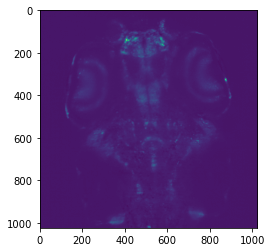

In [28]:
import matplotlib.pyplot as plt

plt.imshow(Y[20,:,:,101])

In [30]:
tr=np.transpose(Y,(3,0,1,2))

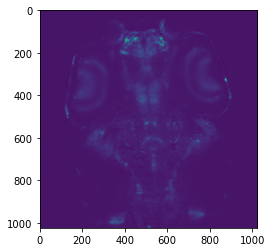

In [31]:
plt.imshow(tr[100,20,:,:])

In [35]:
fn='//ZMN-HIVE/User-Data/Maria/Caiman_MC/fish11_6dpf_medium_cm.h5'
with h5py.File(fn, 'w') as f:
    dset = f.create_dataset("data", data=tr)

In [37]:

with h5py.File(fn, "r") as f:
    # List all groups
    print("Loading raw data from a plane...")
    start=time.time()
    dat=f['data'][()]
    end=time.time()
    print('Time to load raw data file: ',end-start)

Loading raw data from a plane...
Time to load raw data file:  158.11272144317627


In [39]:
import deepdish as dd
dd.io.save(fn, tr, None)